In [1]:
import Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
import Plots
import CSV
import DataFrames as DF
using LaTeXStrings

using FFTW:ifft, fft, fftshift, fftfreq

In [3]:
include("utils.jl")
include("system.jl")
include("constraints.jl")
include("objectives.jl")

steer_to_pops (generic function with 1 method)

In [5]:
V = 10.
p_max = 4
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(V, p_max; acc=0.0 )
# middle index of statevector where p = 0
mid = system.params[:mid]
E_R = system.params[:E_R]
#E_R = 1/0.05
#print("time unit $(1/E_R) ms\nE_R = $E_R kHz")

8.939026187912745

df = DF.DataFrame(CSV.File("./paper_data/split_fig6_coarse.csv"; header=0))

times = df[:,1] * E_R
dts = times[2:end] - times[1:end-1]
#push!(dts, dts[end])
#push!(dts, 0.)
phi = df[1:end-1,2]
#push!(phi, 0.)

duration = sum(dts) # in 1/E_R

T = length(dts)
dt_avg = duration / (T-1)
#dts = zeros(T) .+ dt
dt_bound = (minimum(dts), maximum(dts))
times = cumsum(dts) - dts

a_bound = fill(1., 2)
dda_bound = fill(50., 2)

a = vcat(cos.(phi)', sin.(phi)')

da = NT.derivative(a, dts)
dda = NT.derivative(da, dts)

In [6]:
duration = 0.6 # in units of 1/E_R

T = 401
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts
duration

0.6

In [250]:
a_bound = fill(1., 2)
dda_bound = fill(20000., 2)


a = vcat(ones(T)', zeros(T)')
acc = collect(times')
#a = vcat(cos.(2pi * times/duration)', sin.(2pi * times/duration)')

a = vcat(cos.(1. *sin.(2π* 4. *times))', sin.(1. *sin.(2π* 4. *times))')
#a = 2 * rand(2, T) .- 1

da = NT.derivative(a, dts)
da[:, end] = da[:, end-1]
dda = NT.derivative(da, dts)
#dda[:, end] = dda[:, end-1] = dda[:, end-2]

2×401 Matrix{Float64}:
 -629.04    -622.343   -611.258  -595.901  …   -46.6256   -92.2602  0.0  0.0
  -47.5243   -94.6445  -140.963  -186.093     -547.221   -544.094   0.0  0.0

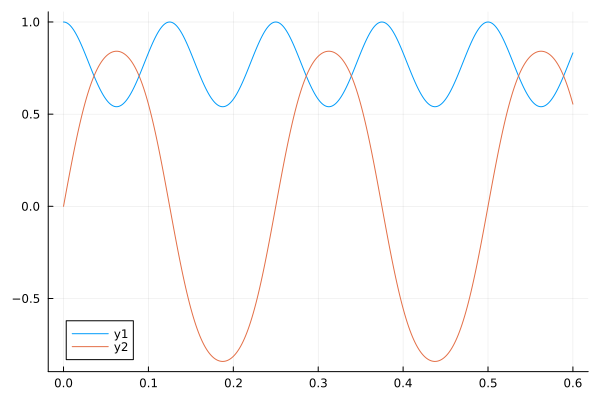

In [251]:
Plots.plot(times, a')

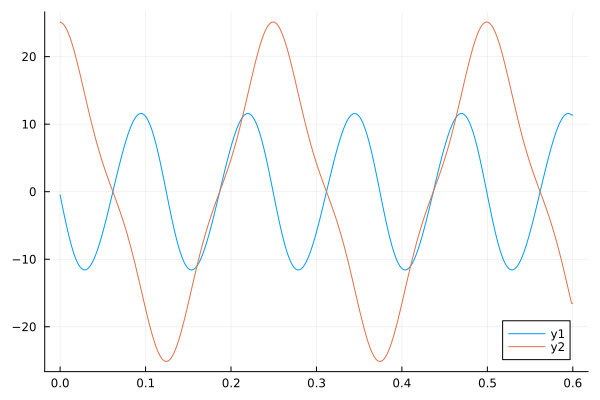

In [252]:
Plots.plot(times, da')

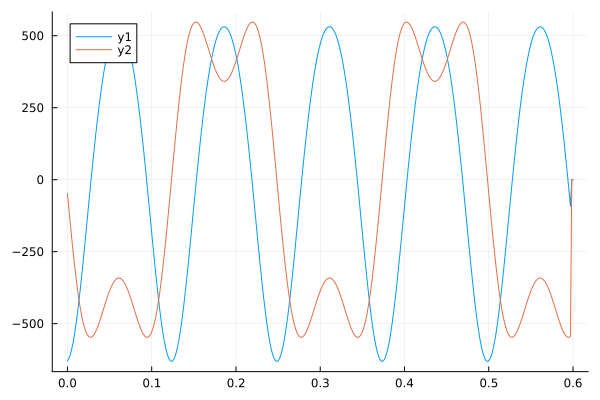

In [253]:
Plots.plot(times, dda')

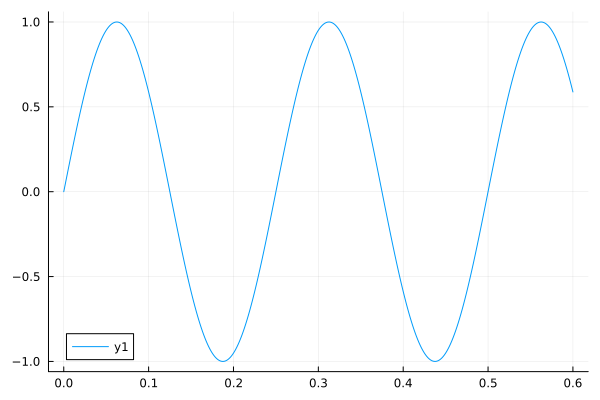

In [254]:
Plots.plot(times, angle.(a[1,:] + 1im*a[2,:]))

psi0 = zeros(system.params[:dim])
psi0[mid] = 0.
psi0[mid-1] = sqrt(0.5)
psi0[mid+1] = sqrt(0.5)
normalize!(psi0)

In [255]:
psi0 = get_bloch_state(system; lvl=0)

9-element Vector{ComplexF64}:
 0.00012655239195148894 - 0.0im
   0.003348732119556511 - 0.0im
    0.05097922316700026 - 0.0im
    0.36682320062722157 - 0.0im
     0.8518575330001765 + 0.0im
    0.36682320062722257 - 0.0im
   0.050979223167000404 - 0.0im
  0.0033487321195565197 - 0.0im
 0.00012655239195148916 - 0.0im

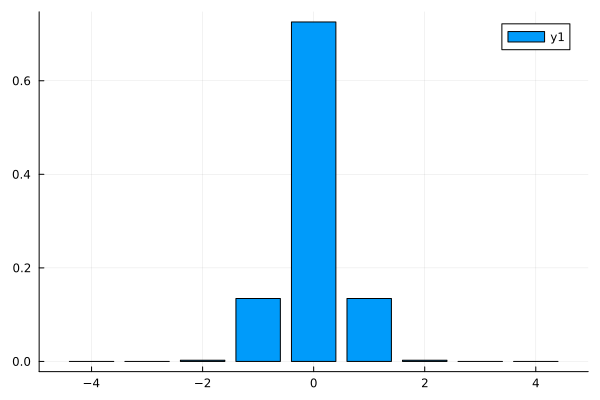

In [256]:
Plots.bar(-p_max:p_max, abs2.(psi0))

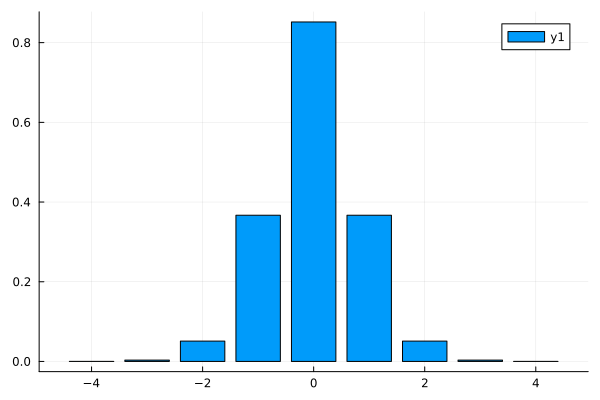

In [257]:
Plots.bar(-p_max:p_max, real.(psi0))

In [258]:
psi0_iso = QC.ket_to_iso(psi0)

18-element Vector{Float64}:
  0.00012655239195148894
  0.003348732119556511
  0.05097922316700026
  0.36682320062722157
  0.8518575330001765
  0.36682320062722257
  0.050979223167000404
  0.0033487321195565197
  0.00012655239195148916
 -0.0
 -0.0
 -0.0
 -0.0
  0.0
 -0.0
 -0.0
 -0.0
 -0.0

In [259]:
psi_iso = QC.rollout(psi0_iso, vcat(a), dts, system; integrator=exp)

18×401 Matrix{Float64}:
  0.000126552  0.000126526  0.000123524  …  -0.00111425   -0.000969472
  0.00334873   0.00334804   0.00330115      -0.013477     -0.0105467
  0.0509792    0.0509687    0.0506151       -0.0506683    -0.0343864
  0.366823     0.366748     0.36581         -0.130717     -0.10977
  0.851858     0.851682     0.851156        -0.289806     -0.308
  0.366823     0.366748     0.367232     …   0.251565      0.237519
  0.0509792    0.0509687    0.0512598       -0.13846      -0.128387
  0.00334873   0.00334804   0.00339099      -0.00982285   -0.00784585
  0.000126552  0.000126526  0.000129401      2.04371e-5    9.09454e-5
 -0.0          2.56786e-6   5.34714e-6       0.000471401   0.000621687
 -0.0          6.79488e-5   0.000137443  …   0.017953      0.0184866
 -0.0          0.00103441   0.00206781       0.2021        0.195648
 -0.0          0.00744317   0.0148561        0.775995      0.771076
  0.0          0.0172849    0.0345505        0.404096      0.418214
 -0.0          

In [260]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(psi_iso[:,t])) for t=1:T]...)

9×401 Matrix{Float64}:
 1.60155e-8  1.60155e-8  1.52868e-8  1.39681e-8  …  1.46377e-6   1.32637e-6
 1.1214e-5   1.1214e-5   1.09165e-5  1.03514e-5     0.000503939  0.00045299
 0.00259888  0.00259888  0.00256617  0.00250204     0.0434117    0.0394606
 0.134559    0.134559    0.134038    0.132999       0.619255     0.606608
 0.725661    0.725661    0.725661    0.725654       0.247281     0.269767
 0.134559    0.134559    0.135081    0.136124    …  0.0695966    0.0648499
 0.00259888  0.00259888  0.00263179  0.00269763     0.0196906    0.0186117
 1.1214e-5   1.1214e-5   1.15164e-5  1.21215e-5     0.000259068  0.000247697
 1.60155e-8  1.60155e-8  1.67678e-8  1.82723e-8     5.62342e-7   5.36025e-7

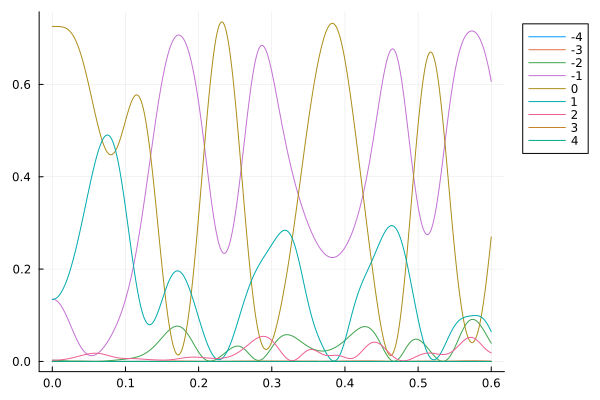

In [261]:
Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright)#, xlim=(0.0, 2.0))

In [264]:
bloch_states = hcat([get_bloch_state(system; lvl=i) for i=0:8]...)

9×9 Matrix{ComplexF64}:
 0.000126552-0.0im   0.000448385-0.0im  …      0.704309+0.0im
  0.00334873-0.0im     0.0108523-0.0im       -0.0626775-0.0im
   0.0509792-0.0im      0.140664-0.0im       0.00325642+0.0im
    0.366823-0.0im      0.692889+0.0im     -0.000135621-0.0im
    0.851858+0.0im   1.88055e-15-0.0im       1.05588e-5+0.0im
    0.366823-0.0im     -0.692889-0.0im  …  -0.000135624-0.0im
   0.0509792-0.0im     -0.140664-0.0im       0.00325648+0.0im
  0.00334873-0.0im    -0.0108523-0.0im       -0.0626787-0.0im
 0.000126552-0.0im  -0.000448385-0.0im         0.704322+0.0im

In [265]:
psi

9×401 Matrix{ComplexF64}:
 0.000126552-0.0im  0.000126526+2.56786e-6im  …  -0.000969472+0.000621687im
  0.00334873-0.0im   0.00334804+6.79488e-5im       -0.0105467+0.0184866im
   0.0509792-0.0im    0.0509687+0.00103441im       -0.0343864+0.195648im
    0.366823-0.0im     0.366748+0.00744317im         -0.10977+0.771076im
    0.851858+0.0im     0.851682+0.0172849im            -0.308+0.418214im
    0.366823-0.0im     0.366748+0.00744317im  …      0.237519-0.0918406im
   0.0509792-0.0im    0.0509687+0.00103441im        -0.128387+0.0461359im
  0.00334873-0.0im   0.00334804+6.79488e-5im      -0.00784585+0.0136433im
 0.000126552-0.0im  0.000126526+2.56786e-6im       9.09454e-5+0.000726467im

In [266]:
blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

9×401 Matrix{Float64}:
 1.0          1.0          0.999999     …  0.418756     0.431859
 2.13711e-32  9.38909e-33  1.15994e-6      0.445721     0.434877
 2.27109e-33  3.05627e-32  1.71371e-10     0.090667     0.0910353
 1.00616e-34  6.82376e-35  6.2926e-8       0.0129813    0.0131783
 2.59853e-34  1.03245e-33  2.20264e-11     0.0316268    0.028839
 1.07564e-36  1.71531e-37  2.70228e-10  …  0.000207041  0.00017315
 2.00235e-36  2.64077e-35  1.16471e-13     4.0481e-5    3.79492e-5
 3.29023e-39  1.13068e-38  1.8559e-13      5.69832e-8   5.04649e-8
 3.45761e-39  1.64958e-37  2.11983e-16     1.81339e-7   1.33255e-7

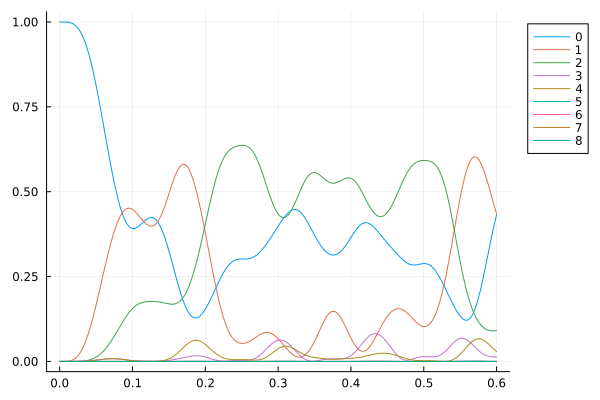

In [267]:
Plots.plot(times, bloch_pops[:,:]', labels=(0:8)', legend=:outertopright)#, xlim=(0.0, 2.0))

In [268]:
pops[:, end]

9-element Vector{Float64}:
 1.3263712459899097e-6
 0.00045298984215610635
 0.03946062745404982
 0.6066083062539165
 0.2697669235920769
 0.06484994057737378
 0.018611652387394668
 0.00024769749648849583
 5.360252973743758e-7

In [269]:
comps = (
    psi_iso = psi_iso,
    a = a,
    acc = acc,
    da = da,
    dda = dda,
    dts = dts
)
initial = (;
    psi_iso = psi0_iso,
    a = [1.; 0.],
    #da = zeros(2)
)
final = (;
    a = [1.; 0.],
    #da = zeros(2)
)
goal = (;)
bounds = (;
    #a = a_bound,
    #dda = dda_bound,
    dts = dt_bound
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:dda),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.00012655239195148894 0.00012652633717340588 … -0.001114247339194257 -0.000969472303177592; 0.003348732119556511 0.0033480426780462444 … -0.013476972438407455 -0.010546735937662493; … ; -47.52426473087704 -94.64445552927003 … 0.0 0.0; 0.0015 0.0015 … 0.0015 0.0015], [0.00012655239195148894, 0.003348732119556511, 0.05097922316700026, 0.36682320062722157, 0.8518575330001765, 0.36682320062722257, 0.050979223167000404, 0.0033487321195565197, 0.00012655239195148916, -0.0  …  0.013643315763263837, 0.000726466952812241, 0.8321708394670709, 0.5545193359484144, 0.6000000000000005, 11.36707199636966, -16.514986792901013, 0.0, 0.0, 0.0015], 401, :dts, 26, (psi_iso = 18, a = 2, acc = 1, da = 2, dda = 2, dts = 1, states = 24, controls = 2), (dts = ([0.0015], [0.0015]),), (psi_iso = [0.00012655239195148894, 0.003348732119556511, 0.05097922316700026, 0.36682320062722157, 0.8518575330001765, 0.36682320062722257, 0.050979223167000404, 0

Z_guess = NT.copy(Z_save)

NT.update_bounds!(Z_guess, :dda, [-5000. -5000.; 5000. 5000.])

In [271]:
state_goal = get_bloch_state(system; lvl=5)

9-element Vector{ComplexF64}:
    -0.06259471962880768 - 0.0im
     -0.6988022782025717 - 0.0im
      0.0878093384489113 + 0.0im
  -0.0068408206016502765 - 0.0im
 -2.9526132319013044e-13 - 0.0im
    0.006840820605912697 + 0.0im
    -0.08780933850303342 - 0.0im
      0.6988022786332382 + 0.0im
      0.0625947196673841 - 0.0im

In [272]:
pops_goal = abs2.(state_goal)

9-element Vector{Float64}:
 0.003918098925409041
 0.4883246240211044
 0.007710479918835452
 4.679682650396285e-5
 8.717924897198665e-26
 4.679682656227976e-5
 0.0077104799283403075
 0.48832462462300585
 0.003918098930238402

In [273]:
dim = system.params[:dim]
# J = NameComponentPathObjective(
#     :psi_iso,
#     1:dim,
#     [1:T...],
#     [time -> pop for pop in pops_goal],
#     [x -> abs2.(x) for _=1:dim],
#     collect(1:T)' .* fill(1., dim, T);
#     is_iso=true
# )

# J = NameComponentPathObjective(
#     :psi_iso,
#     1:2*dim,
#     [1:T...],
#     [time -> s for s in QC.ket_to_iso(state_goal)],
#     [x -> x for _=1:2*dim],
#     collect(1:T)' .* fill(1., 2*dim, T);
#     is_iso=false
# )

# J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, ones(1)*1e-1; is_iso=false)

# J = NameComponentObjective(:psi_iso, [mid-1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid+1], steer_to_pops([0.5]), 1.0; is_iso=true)
# J += NameComponentObjective(:psi_iso, [mid], steer_to_pops([0.0]), 1.0; is_iso=true)

#J += NameComponentQuadraticRegularizer(:psi_iso, [mid-2, mid+2], Z_guess, ones(2)*1e-3; is_iso=true)
# J += NameComponentQuadraticRegularizer(:psi_iso, [mid-1, mid+1], Z_guess, ones(2)*1e-3; is_iso=true)

#J = NameComponentObjective(:psi_iso, [1:dim...], [1:T...], x -> 1 - abs2.(x' * state_goal), ([1:T...] ./ T) .* 100.; is_iso=true)
J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(state_goal), loss=:InfidelityLoss, Q=100.0)
#J += QC.QuadraticRegularizer(:dts, Z_guess, 0.01)
#J += NameComponentQuadraticRegularizer(:a, [2], Z_guess, [0.001])
J += QC.QuadraticRegularizer(:dda, Z_guess, 1e-10/T)

QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#L#21"{Vector{QuantumCollocation.Losses.InfidelityLoss}}(Core.Box((:psi_iso,)), Core.Box(:InfidelityLoss), Core.Box([100.0]), QuantumCollocation.Losses.InfidelityLoss[QuantumCollocation.Losses.InfidelityLoss(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([-0.06259471962880768, -0.6988022782025717, 0.0878093384489113, -0.0068408206016502765, -2.9526132319013044e-13, 0.006840820605912697, -0.08780933850303342, 0.6988022786332382, 0.0625947196673841, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0]), QuantumCollocation.Losses.var"#23#26"{QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}}(QuantumCollocation.Losses.var"#22#25"{Vector{Float64}}([-0.06259471962880768, -0.6988022782025717, 0.0878093384489113, -0.0068408206016502765, -2.95261323190

In [274]:
J.L(Z_guess.datavec, Z_guess)

99.98270228220473

In [275]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        (:a),# :acc),
        :dts;
        order=4
    ),
    QC.DerivativeIntegrator(
        :a,
        :da,
        :dts,
        Z_guess
    ),
    QC.DerivativeIntegrator(
        :da,
        :dda,
        :dts,
        Z_guess
    )
]

3-element Vector{QuantumCollocation.Integrators.AbstractIntegrator}:
 QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [402.1238596594935 0.0 … 0.0 0.0; 0.0 226.1946710584651 … 0.0 0.0; … ; 0.0 0.0 … 226.1946710584651 0.0; 0.0 0.0 … 0.0 402.1238596594935], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-0.0 -15.707963267948966 … -0.0 -0.0; -15.707963267948966 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -15.707963267948966; -0.0 -0.0 … -15.707963267948966 -0.0], [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0]], [[-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], [-0.0 -15.707963267948966 … -0.0 -0.0; 15.707963267948966 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -15.707963267948966; -0.0 -0.0 … 15.707963267948966 -0.0]], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [161703.59850744804 0.0 … 0.0

In [178]:
import Ipopt
import MathOptInterface as MOI

In [42]:
U = get_shaken_lattice_propagator(system, 1., 0.0, 1000; return_iso_operator=false)
U_bloch = bloch_states' * U * bloch_states

9×9 Matrix{ComplexF64}:
     0.572028+0.820234im     …   5.76032e-18+2.87716e-19im
  7.52237e-15+6.07477e-15im      1.02903e-17+6.4077e-18im
  1.20368e-15-2.27825e-15im     -1.45753e-17-1.54718e-17im
 -8.13828e-16+3.0335e-16im       2.85114e-17-1.12494e-17im
 -1.50627e-16+1.45519e-15im     -3.87464e-17+4.76051e-18im
  1.21822e-16-6.67445e-17im  …   2.56315e-16-8.30722e-17im
 -9.11894e-17+7.37419e-17im     -1.54045e-17+4.16133e-16im
 -3.94436e-18+3.31564e-18im     -3.79215e-13-5.39451e-14im
  9.56909e-18+5.59099e-18im         0.172062-0.985086im

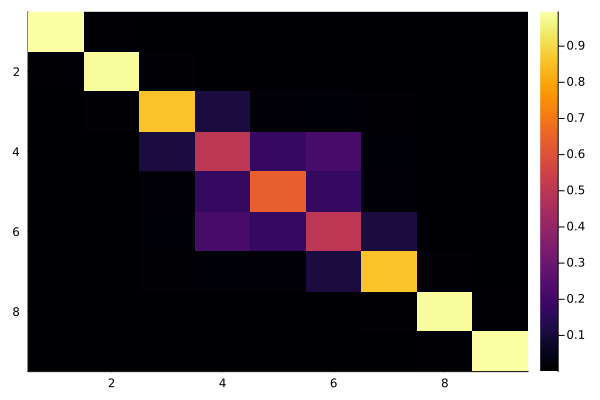

In [43]:
Plots.heatmap(abs2.(U), yflip=true)

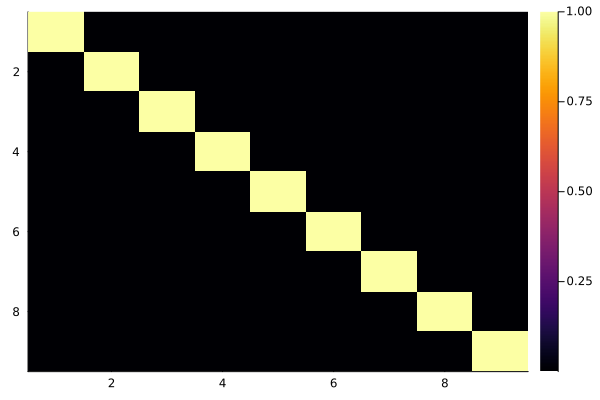

In [44]:
Plots.heatmap(abs2.(U_bloch), yflip=true)

In [46]:
jumps = [(200, 0.0015)]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, 1000)

1-element Vector{Matrix{Float64}}:
 [0.8232915427675951 0.010664137220992218 … 7.811228193038378e-16 5.844140200306135e-19; 0.010664137220992239 0.9424716744895364 … -3.5658630664130993e-14 7.8112281930384e-16; … ; -7.811228193038598e-16 3.565863066413155e-14 … 0.9424716744895343 0.010664137220991575; -5.844140200306256e-19 -7.81122819303843e-16 … 0.010664137220991564 0.8232915427673999]

In [276]:
constraints = [
    OmegaAbsConstraint(1.0, Z_guess),
    vcat([get_link_constraints(
        :psi_iso, 
        Z_guess, 
        c, 
        g, 
        (; a=[1.0,0.0]), 
        (; a=[1.0,0.0]); 
        hard_equality_constraint=true)
        for (c, g) in zip(cuts, G)]...)...,
    TimeAffineLinearControlConstraint(:acc, 1, Z_guess; jumps=jumps)
    #PhiFunctionBoundConstraint(phase_bound, Z_guess),
    #TimeSymmetricControlConstraint(:a, Z_guess)
]

5-element Vector{QuantumCollocation.Constraints.AbstractConstraint}:
 QuantumCollocation.Constraints.NonlinearEqualityConstraint(QuantumCollocation.Constraints.var"#g#30"{UnitRange{Int64}, UnitRange{Int64}, Int64, QuantumCollocation.Constraints.var"#gₜ#27"{Float64}}(19:20, 1:401, 26, QuantumCollocation.Constraints.var"#gₜ#27"{Float64}(1.0)), QuantumCollocation.Constraints.var"#∂g#31"{QuantumCollocation.Constraints.var"#∂g#23#32"{UnitRange{Int64}, UnitRange{Int64}, Int64, Int64, Vector{Any}, QuantumCollocation.Constraints.var"#∂gₜ#28"}}(QuantumCollocation.Constraints.var"#∂g#23#32"{UnitRange{Int64}, UnitRange{Int64}, Int64, Int64, Vector{Any}, QuantumCollocation.Constraints.var"#∂gₜ#28"}(19:20, 1:401, 26, 401, Any[(1, 19), (1, 20), (2, 45), (2, 46), (3, 71), (3, 72), (4, 97), (4, 98), (5, 123), (5, 124)  …  (397, 10315), (397, 10316), (398, 10341), (398, 10342), (399, 10367), (399, 10368), (400, 10393), (400, 10394), (401, 10419), (401, 10420)], QuantumCollocation.Constraints.var"#∂gₜ#2

In [277]:
constraints = constraints[[1,5]]

2-element Vector{QuantumCollocation.Constraints.AbstractConstraint}:
 QuantumCollocation.Constraints.NonlinearEqualityConstraint(QuantumCollocation.Constraints.var"#g#30"{UnitRange{Int64}, UnitRange{Int64}, Int64, QuantumCollocation.Constraints.var"#gₜ#27"{Float64}}(19:20, 1:401, 26, QuantumCollocation.Constraints.var"#gₜ#27"{Float64}(1.0)), QuantumCollocation.Constraints.var"#∂g#31"{QuantumCollocation.Constraints.var"#∂g#23#32"{UnitRange{Int64}, UnitRange{Int64}, Int64, Int64, Vector{Any}, QuantumCollocation.Constraints.var"#∂gₜ#28"}}(QuantumCollocation.Constraints.var"#∂g#23#32"{UnitRange{Int64}, UnitRange{Int64}, Int64, Int64, Vector{Any}, QuantumCollocation.Constraints.var"#∂gₜ#28"}(19:20, 1:401, 26, 401, Any[(1, 19), (1, 20), (2, 45), (2, 46), (3, 71), (3, 72), (4, 97), (4, 98), (5, 123), (5, 124)  …  (397, 10315), (397, 10316), (398, 10341), (398, 10342), (399, 10367), (399, 10368), (400, 10393), (400, 10394), (401, 10419), (401, 10420)], QuantumCollocation.Constraints.var"#∂gₜ#2

In [278]:
# Ipopt options
options = QC.Options(
    max_iter=1000,
)

QuantumCollocation.IpoptOptions.Options{Float64}(1.0e-8, 100.0, 1000, 1.0e6, 1.0, 1.0e-12, 0.001, 1.0e-6, 15, 1.0e10, 0.01, 0.01, 1.0e-5, 1.0e8, 0.0001, 5, nothing, "no", "no", "no", "text", "no", "no", "original", 1, 0.0, "no", nothing, "mumps", 10, 3)

In [279]:
dynamics = QC.QuantumDynamics(
    integrators,
    Z_guess;
    #cuts=cuts
)

QuantumCollocation.Dynamics.QuantumDynamics(QuantumCollocation.Integrators.AbstractIntegrator[QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [402.1238596594935 0.0 … 0.0 0.0; 0.0 226.1946710584651 … 0.0 0.0; … ; 0.0 0.0 … 226.1946710584651 0.0; 0.0 0.0 … 0.0 402.1238596594935], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-0.0 -15.707963267948966 … -0.0 -0.0; -15.707963267948966 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -15.707963267948966; -0.0 -0.0 … -15.707963267948966 -0.0], [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0]], [[-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], [-0.0 -15.707963267948966 … -0.0 -0.0; 15.707963267948966 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -15.707963267948966; -0.0 -0.0 … 15.707963267948966 -0.0]], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1617

In [281]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    dynamics;
    constraints=constraints,
    options=options,
)

applying constraint: initial value of psi_iso
applying constraint: initial value of a
applying constraint: final value of a
applying constraint: bounds on dts
applying constraint: time affine linear control constraint


QuantumCollocation.Problems.QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(27) … MOI.VariableIndex(10375) MOI.VariableIndex(10401); MOI.VariableIndex(2) MOI.VariableIndex(28) … MOI.VariableIndex(10376) MOI.VariableIndex(10402); … ; MOI.VariableIndex(25) MOI.VariableIndex(51) … MOI.VariableIndex(10399) MOI.VariableIndex(10425); MOI.VariableIndex(26) MOI.VariableIndex(52) … MOI.VariableIndex(10400) MOI.VariableIndex(10426)], QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([402.1238596594935 0.0 … 0.0 0.0; 0.0 226.1946710584651 … 0.0 0.0; … ; 0.0 0.0 … 226.1946710584651 0.0; 0.0 0.0 … 0.0 402.1238596594935], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-0.0 -15.707963267948966 … -0.0 -0.0; -15.707963267948966 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -15.707963267948966; -0.0 -0.0 … -15.707963267948966 -0.0], [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -

In [282]:
QC.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:   143405
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    30499

Total number of variables............................:    10003
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     9602
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9982702e+01 5.55e-01 1.76e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1  9.9554690e+01 6.21e-01 1.22e+06  -1.0 4.49e+04  -4.0 1.00e+00 1.00e+00H  1


   2  9.9854716e+01 3.42e-01 6.14e+05  -1.0 4.72e+03  -3.6 1.00e+00 5.00e-01h  2


   3  9.9977377e+01 6.11e-02 3.86e+03  -1.0 7.83e+03  -4.1 1.00e+00 1.00e+00h  1


   4  9.9959029e+01 5.89e-03 5.17e+03  -1.0 5.24e+03  -4.5 1.00e+00 1.00e+00h  1


   5  9.9960046e+01 7.39e-04 8.09e+02  -1.0 8.50e+02  -5.0 1.00e+00 1.00e+00h  1


   6  9.9960928e+01 4.75e-05 2.46e+01  -1.0 8.57e+02  -5.5 1.00e+00 1.00e+00h  1


   7  9.9960706e+01 1.37e-05 2.17e-01  -1.0 5.94e+01  -6.0 1.00e+00 1.00e+00h  1


   8  9.9960015e+01 3.72e-06 2.97e-02  -1.7 2.40e+01  -6.4 1.00e+00 1.00e+00h  1


   9  9.9957887e+01 3.53e-05 5.14e-03  -2.5 2.04e+01  -6.9 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.9950417e+01 4.06e-04 1.96e-04  -3.8 6.69e+01  -7.4 1.00e+00 1.00e+00h  1


  11  9.9910876e+01 8.87e-03 2.37e-03  -4.0 2.76e+02  -7.9 1.00e+00 1.00e+00h  1


  12  9.9886654e+01 1.88e-03 5.75e-04  -4.0 1.23e+02  -7.4 1.00e+00 1.00e+00h  1


  13  9.9729206e+01 5.48e-02 1.46e-02  -4.0 5.69e+02  -7.9 1.00e+00 1.00e+00h  1


  14  9.9601535e+01 1.47e-02 6.61e-03  -4.0 2.65e+02  -7.5 1.00e+00 1.00e+00h  1


  15  9.7395114e+01 8.83e-01 3.36e-01  -4.0 2.03e+03  -8.0 1.00e+00 1.00e+00h  1


  16  9.6534325e+01 1.19e-01 3.75e-01  -4.0 3.77e+02  -6.6 1.00e+00 1.00e+00h  1


  17  9.5630557e+01 3.14e-02 1.63e-01  -4.0 4.15e+02  -7.1 1.00e+00 1.00e+00h  1


  18  9.4848651e+01 1.33e-02 1.29e-02  -4.0 1.72e+02  -6.7 1.00e+00 1.00e+00h  1


  19  8.8161597e+01 1.07e+00 6.00e-01  -4.0 1.22e+03  -7.2 1.00e+00 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.9373217e+01 2.54e-01 1.18e+00  -4.0 1.23e+03  -6.7 1.00e+00 1.00e+00f  1


  21  8.1704595e+01 2.06e-02 3.58e-01  -4.0 4.25e+02  -6.3 1.00e+00 1.00e+00h  1


  22  7.8034598e+01 8.16e-03 1.66e-01  -4.0 5.91e+02  -6.8 1.00e+00 1.00e+00f  1


  23  5.3146308e+01 1.81e-01 5.51e-01  -4.0 2.56e+03  -7.3 1.00e+00 1.00e+00f  1


  24  4.6866922e+01 1.96e-02 3.76e-01  -4.0 8.69e+02  -6.8 1.00e+00 1.00e+00f  1


  25  1.8816576e+01 8.01e-01 2.17e+00  -4.0 3.66e+03  -7.3 1.00e+00 1.00e+00f  1


  26  1.7968782e+01 9.56e-02 1.30e+00  -4.0 1.04e+03  -6.9 1.00e+00 1.00e+00h  1


  27  9.7644920e+00 2.61e-02 4.40e-01  -4.0 1.45e+03  -7.4 1.00e+00 1.00e+00f  1


  28  1.8238441e+00 2.61e-02 2.31e-01  -4.0 2.01e+03  -7.9 1.00e+00 1.00e+00f  1


  29  1.1975056e-02 2.27e-02 2.47e+02  -4.0 2.44e+03  -8.3 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  3.3010055e+00 2.04e-02 2.43e+02  -4.0 3.43e+03  -8.8 1.00e+00 1.00e+00H  1


  31  3.5405951e+00 1.05e-04 1.41e-01  -4.0 7.59e+01  -5.7 1.00e+00 1.00e+00h  1


  32  3.5225592e+00 2.94e-05 4.37e-02  -4.0 3.37e+01  -6.1 1.00e+00 1.00e+00h  1


  33  3.3790679e+00 1.09e-04 9.92e-04  -4.0 9.97e+01  -6.6 1.00e+00 1.00e+00f  1


  34  3.0347917e+00 4.86e-04 2.12e-03  -4.0 2.72e+02  -7.1 1.00e+00 1.00e+00f  1


  35  2.2984200e+00 1.83e-03 1.01e-02  -4.0 6.36e+02  -7.6 1.00e+00 1.00e+00f  1


  36  1.1345932e+00 6.28e-03 2.35e-02  -4.0 1.30e+03  -8.1 1.00e+00 1.00e+00f  1


  37  1.4295445e-01 1.28e-02 3.15e-02  -4.0 2.04e+03  -8.5 1.00e+00 1.00e+00f  1


  38  4.1108361e-02 1.39e-02 6.67e-02  -4.0 2.39e+03  -9.0 1.00e+00 1.00e+00H  1


  39  1.0790674e-01 5.97e-03 2.66e+02  -4.0 1.18e+03  -9.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  6.1457604e-02 2.31e-03 2.66e+02  -4.0 4.11e+02  -9.1 1.00e+00 1.00e+00h  1


  41  1.1325927e-02 1.41e-06 2.66e+02  -4.0 5.92e+00  -5.9 1.00e+00 1.00e+00h  1


  42  5.8659892e-02 3.40e-07 2.66e+02  -4.0 2.95e+00  -6.4 1.00e+00 1.00e+00h  1


  43  1.1226470e-02 4.85e-07 2.66e+02  -4.0 2.41e+00  -6.0 1.00e+00 1.00e+00f  1


  44  5.8742197e-02 3.40e-07 2.66e+02  -4.0 3.34e+00  -6.5 1.00e+00 1.00e+00h  1


  45  1.1157572e-02 6.12e-07 2.66e+02  -4.0 2.75e+00  -6.0 1.00e+00 1.00e+00f  1


  46  5.8849683e-02 3.40e-07 2.66e+02  -4.0 3.76e+00  -6.5 1.00e+00 1.00e+00h  1


  47  1.1052054e-02 6.64e-07 2.66e+02  -4.0 2.91e+00  -6.1 1.00e+00 1.00e+00f  1


  48  5.9004876e-02 3.40e-07 2.66e+02  -4.0 4.18e+00  -6.6 1.00e+00 1.00e+00h  1


  49  1.0884018e-02 4.52e-07 2.67e+02  -4.0 2.74e+00  -6.1 1.00e+00 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.9218797e-02 3.40e-07 2.66e+02  -4.0 4.59e+00  -6.6 1.00e+00 1.00e+00h  1


  51  1.0484323e-02 3.40e-07 2.67e+02  -4.0 2.93e-01  -5.3 1.00e+00 1.00e+00f  1


  52  2.4705029e-02 2.73e-05 2.66e+02  -4.0 8.24e-01  -5.8 1.00e+00 1.00e+00H  1


  53  1.0444747e-02 3.40e-07 2.67e+02  -4.0 3.36e-01  -5.3 1.00e+00 1.00e+00f  1


  54  2.7418679e-02 5.18e-09 1.33e+02  -4.0 9.39e-01  -5.8 1.00e+00 5.00e-01h  2


  55  1.1223525e-02 1.79e-07 1.68e-03  -4.0 3.03e+00  -6.3 1.00e+00 1.00e+00f  1


  56  2.6636565e-02 6.40e-07 1.32e-05  -4.0 6.34e+00  -6.8 1.00e+00 1.00e+00h  1


  57  2.5603676e-02 3.15e-06 2.02e-05  -4.0 1.40e+01  -7.2 1.00e+00 1.00e+00h  1


  58  2.4339024e-02 7.83e-08 3.02e-05  -4.0 3.56e+01  -7.7 1.00e+00 1.00e+00H  1


  59  2.2267878e-02 3.05e-07 5.68e-05  -4.0 8.00e+01  -8.2 1.00e+00 1.00e+00F  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.0012858e-02 2.82e-06 1.35e-04  -4.0 1.27e+02  -8.7 1.00e+00 1.00e+00H  1


  61  1.8955585e-02 1.95e-06 1.67e-04  -4.0 1.16e+02  -9.1 1.00e+00 1.00e+00H  1


  62  1.8881880e-02 4.21e-07 1.26e-05  -4.0 2.71e+01  -8.7 1.00e+00 1.00e+00H  1


  63  1.8283875e-02 1.27e-05 5.32e-05  -4.0 5.20e+01  -9.2 1.00e+00 1.00e+00h  1


  64  1.8243119e-02 3.57e-04 2.68e+02  -4.0 2.06e+02  -9.7 1.00e+00 5.00e-01h  2


  65  8.6185512e-03 1.54e-03 1.34e+02  -4.0 8.45e+02 -10.2 1.00e+00 5.00e-01h  2


  66  3.0376476e-03 6.19e-07 3.28e-03  -4.0 6.99e+00  -6.1 1.00e+00 1.00e+00h  1


  67  1.9020431e-02 2.08e-08 1.23e-05  -4.0 8.19e-01  -6.6 1.00e+00 1.00e+00h  1


  68  1.8991731e-02 9.29e-08 6.80e-07  -4.0 1.73e+00  -7.1 1.00e+00 1.00e+00h  1


  69  1.8952159e-02 2.59e-07 1.31e-06  -4.0 3.06e+00  -7.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.8918151e-02 5.45e-08 3.20e-06  -4.0 6.00e+00  -8.0 1.00e+00 1.00e+00H  1


  71  1.8863591e-02 2.34e-06 7.35e-06  -4.0 1.25e+01  -8.5 1.00e+00 1.00e+00h  1


  72  1.8838638e-02 1.11e-06 2.24e-05  -4.0 3.14e+01  -9.0 1.00e+00 1.00e+00H  1


  73  1.8779234e-02 9.71e-07 2.20e-05  -4.0 9.49e+01  -9.5 1.00e+00 1.25e-01h  4


  74  1.8711016e-02 1.57e-06 2.26e-05  -4.0 3.48e+01  -9.0 1.00e+00 1.00e+00H  1


  75  1.8643259e-02 1.82e-06 2.27e-05  -4.0 1.09e+02  -9.5 1.00e+00 1.25e-01h  4


  76  1.8621874e-02 2.10e-06 2.31e-05  -4.0 3.24e+02 -10.0 1.00e+00 3.12e-02h  6


  77  1.3855321e-02 7.72e-05 2.47e-04  -4.0 1.23e+02  -9.6 1.00e+00 1.00e+00h  1


  78  4.9334941e-03 2.57e-04 2.70e+02  -4.0 3.72e+02 -10.0 1.00e+00 5.00e-01h  2


  79  4.2956032e-03 2.41e-04 1.69e+01  -4.0 1.13e+03 -10.5 1.00e+00 6.25e-02h  5


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.6542571e-02 2.13e-08 9.03e-05  -4.0 1.62e+00  -7.4 1.00e+00 1.00e+00h  1


  81  1.8528873e-02 5.73e-08 7.10e-07  -4.0 2.37e+00  -7.9 1.00e+00 1.00e+00h  1


  82  1.8516997e-02 3.94e-08 1.63e-06  -4.0 6.87e+00  -8.3 1.00e+00 1.00e+00H  1


  83  1.8486842e-02 6.29e-07 8.87e-06  -4.0 2.05e+01  -8.8 1.00e+00 1.00e+00H  1


  84  1.8475794e-02 5.90e-07 8.64e-06  -4.0 6.35e+01  -9.3 1.00e+00 6.25e-02h  5


  85  3.3450109e-03 2.38e-04 2.71e+02  -4.0 1.92e+02  -9.8 1.00e+00 1.00e+00h  1


  86r 3.3450109e-03 2.38e-04 9.99e+02  -3.6 0.00e+00 -10.2 0.00e+00 4.77e-07R 22
  87r 3.2412039e-03 6.03e-05 1.01e+01  -3.6 1.20e+03    -  1.00e+00 9.91e-04f  1


  88  3.0905702e-03 1.11e-04 1.35e+02  -4.0 2.97e+05    -  1.00e+00 2.44e-04h 13


  89  7.6439041e-03 4.59e-06 1.08e-02  -4.0 1.56e+01  -6.2 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.3771480e-02 3.85e-06 5.42e-03  -4.0 1.87e+01  -6.7 1.00e+00 5.00e-01h  2


  91  1.9017228e-02 6.08e-08 4.33e-04  -4.0 2.67e+01  -7.2 1.00e+00 1.00e+00H  1


  92  1.8403287e-02 2.28e-07 6.80e-05  -4.0 1.42e+01  -7.6 1.00e+00 1.00e+00H  1


  93  1.8321743e-02 1.06e-07 3.82e-06  -4.0 7.06e+00  -8.1 1.00e+00 1.00e+00H  1


  94  1.8306906e-02 8.77e-08 4.35e-06  -4.0 1.26e+01  -8.6 1.00e+00 1.00e+00H  1


  95  1.7736696e-02 8.48e-06 3.12e-05  -4.0 3.64e+01  -9.1 1.00e+00 1.00e+00h  1


  96  1.2518295e-02 8.56e-05 2.68e-04  -4.0 1.11e+02  -9.5 1.00e+00 1.00e+00h  1


  97  1.1556972e-02 4.08e-04 2.72e+02  -4.0 1.04e+03 -10.5 1.00e+00 2.50e-01h  3


  98  8.4990701e-03 3.13e-04 6.81e+01  -4.0 4.63e+02 -10.1 1.00e+00 2.50e-01h  3


  99  9.9920615e-03 8.52e-08 5.74e-04  -4.0 1.85e+00  -6.0 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7962014e-02 1.69e-09 1.94e-06  -4.0 2.86e-01  -6.5 1.00e+00 1.00e+00h  1


 101  1.7959313e-02 3.04e-09 1.71e-07  -4.0 5.31e-01  -7.0 1.00e+00 1.00e+00h  1


 102  1.7956113e-02 1.62e-08 3.71e-07  -4.0 1.01e+00  -7.5 1.00e+00 1.00e+00h  1


 103  1.7948738e-02 7.22e-08 7.87e-07  -4.0 2.66e+00  -7.9 1.00e+00 1.00e+00h  1


 104  1.7916348e-02 4.10e-07 1.99e-06  -4.0 8.12e+00  -8.4 1.00e+00 1.00e+00h  1


 105  1.7943498e-02 5.44e-07 1.43e-05  -4.0 2.46e+01  -8.9 1.00e+00 1.00e+00H  1


 106  1.7899733e-02 5.91e-07 1.45e-05  -4.0 7.34e+01  -9.4 1.00e+00 1.25e-01h  4


 107  1.7918767e-02 5.59e-07 1.77e-05  -4.0 2.76e+01  -8.9 1.00e+00 1.00e+00H  1


 108  1.7838085e-02 7.95e-07 1.79e-05  -4.0 8.21e+01  -9.4 1.00e+00 1.25e-01h  4


 109  1.7798324e-02 1.05e-06 1.47e-05  -4.0 3.10e+01  -9.0 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.3006694e-02 6.80e-05 2.04e-04  -4.0 9.21e+01  -9.5 1.00e+00 1.00e+00h  1


 111  4.6778059e-03 2.14e-04 2.74e+02  -4.0 2.71e+02  -9.9 1.00e+00 5.00e-01h  2


 112r 4.6778059e-03 2.14e-04 9.99e+02  -3.7 0.00e+00 -10.4 0.00e+00 4.77e-07R 22
 113r 4.5539635e-03 5.40e-05 9.07e+00  -3.7 8.41e+02    -  1.00e+00 9.91e-04f  1


 114  3.3087616e-03 4.96e-03 1.37e+02  -4.0 2.69e+05    -  1.00e+00 1.95e-03h 10


 115  4.4941950e-03 4.88e-03 1.35e+02  -4.0 2.29e+02  -6.4 1.00e+00 1.56e-02h  7


 116  4.5373112e-03 4.88e-03 1.35e+02  -4.0 6.23e+01  -6.0 1.00e+00 1.22e-04h 14


 117  3.5979615e-03 4.58e-03 1.27e+02  -4.0 2.82e+02  -6.4 1.00e+00 6.25e-02h  5


 118  4.2254503e-03 4.57e-03 1.26e+02  -4.0 6.68e+01  -6.0 1.00e+00 1.95e-03h 10


 119  3.5685959e-03 4.43e-03 1.51e+02  -4.0 3.07e+02  -6.5 1.00e+00 3.12e-02h  6


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.3723154e+00 3.69e-03 2.72e+02  -4.0 4.59e+02  -7.0 1.00e+00 1.00e+00h  1


 121  1.5388204e+00 9.29e-05 8.66e-02  -4.0 5.59e+01  -5.6 1.00e+00 1.00e+00h  1


 122  1.1237823e+00 2.90e-04 1.07e-02  -4.0 1.24e+02  -6.1 1.00e+00 1.00e+00f  1


 123  3.7023852e-01 1.14e-03 3.10e-02  -4.0 2.50e+02  -6.6 1.00e+00 1.00e+00f  1


 124  1.0156689e-01 1.62e-03 2.72e+02  -4.0 3.02e+02  -7.1 1.00e+00 1.00e+00f  1


 125  2.7109307e-01 5.06e-04 2.71e+02  -4.0 1.76e+02  -7.5 1.00e+00 1.00e+00h  1


 126  2.4346439e-01 2.08e-06 1.18e-02  -4.0 8.55e+00  -5.3 1.00e+00 1.00e+00h  1


 127  2.4223794e-01 1.03e-05 1.01e-03  -4.0 2.33e+01  -5.8 1.00e+00 1.00e+00h  1


 128  1.6854421e-01 5.99e-05 1.43e-03  -4.0 5.63e+01  -6.3 1.00e+00 1.00e+00f  1


 129  6.7681262e-02 1.87e-04 4.24e-03  -4.0 9.99e+01  -6.7 1.00e+00 1.00e+00f  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.7085196e-02 2.11e-04 4.01e-03  -4.0 1.06e+02  -7.2 1.00e+00 1.00e+00h  1


 131  1.1758882e-02 1.35e-04 1.05e-03  -4.0 8.48e+01  -7.7 1.00e+00 1.00e+00h  1


 132  1.5364418e-02 5.03e-05 3.07e-04  -4.0 5.01e+01  -8.2 1.00e+00 1.00e+00h  1


 133  1.7371547e-02 5.99e-06 2.46e-05  -4.0 3.04e+01  -8.7 1.00e+00 1.00e+00h  1


 134  1.6776900e-02 1.21e-05 4.64e-05  -4.0 4.37e+01  -9.1 1.00e+00 1.00e+00h  1


 135  9.6414091e-03 9.55e-05 2.36e-04  -4.0 3.69e+02 -10.1 1.00e+00 2.50e-01h  3


 136  4.8710822e-03 1.63e-04 4.54e-04  -4.0 1.38e+02  -9.7 1.00e+00 1.00e+00h  1


 137  1.5737496e-02 2.17e-05 6.42e-05  -4.0 5.25e+01  -9.2 1.00e+00 1.00e+00h  1


 138  1.2000616e-02 6.66e-05 1.73e-04  -4.0 1.54e+02  -9.7 1.00e+00 5.00e-01h  2


 139  1.4915102e-02 2.92e-05 7.98e-05  -4.0 5.81e+01  -9.3 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  9.9716510e-03 8.77e-05 2.26e-04  -4.0 1.70e+02  -9.8 1.00e+00 5.00e-01h  2


 141  4.2798958e-03 1.07e-04 2.80e-04  -4.0 1.18e+03 -10.2 1.00e+00 6.25e-02h  5


 142  4.0876290e-03 1.13e-04 2.96e-04  -4.0 5.62e+02 -10.3 1.00e+00 6.25e-02h  5


 143  3.5095703e-03 1.29e-04 2.75e+02  -4.0 1.70e+03 -10.8 1.00e+00 1.56e-02h  7


 144  3.4106541e-03 1.27e-04 4.29e+00  -4.0 6.37e+02 -10.3 1.00e+00 1.56e-02h  7


 145  1.6425069e-02 4.79e-07 1.02e-04  -4.0 4.11e+00  -8.1 1.00e+00 1.00e+00h  1


 146  1.6966579e-02 1.02e-07 3.54e-06  -4.0 1.14e+01  -8.6 1.00e+00 1.00e+00H  1


 147  1.6056248e-02 1.06e-05 2.95e-05  -4.0 3.43e+01  -9.1 1.00e+00 1.00e+00h  1


 148  7.9818040e-03 1.10e-04 2.88e-04  -4.0 1.02e+02  -9.5 1.00e+00 1.00e+00h  1


 149  8.1748238e-03 1.07e-04 2.80e-04  -4.0 2.95e+02 -10.0 1.00e+00 6.25e-02h  5


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.3701777e-02 3.10e-05 2.87e-04  -4.0 1.13e+02  -9.6 1.00e+00 1.00e+00H  1


 151  1.5020112e-02 1.80e-05 5.01e-05  -4.0 4.20e+01  -9.2 1.00e+00 1.00e+00h  1


 152  1.2255477e-02 4.99e-05 1.37e-04  -4.0 1.24e+02  -9.6 1.00e+00 5.00e-01h  2


 153  1.4563189e-02 2.16e-05 6.10e-05  -4.0 4.68e+01  -9.2 1.00e+00 1.00e+00h  1


 154  1.6080972e-02 2.96e-06 8.86e-06  -4.0 1.75e+01  -8.8 1.00e+00 1.00e+00h  1


 155  1.3960768e-02 2.75e-05 7.73e-05  -4.0 5.21e+01  -9.3 1.00e+00 1.00e+00h  1


 156  9.5983348e-03 7.83e-05 2.15e-04  -4.0 1.53e+02  -9.7 1.00e+00 5.00e-01h  2


 157  1.5722570e-02 4.60e-06 1.35e-05  -4.0 2.17e+01  -8.9 1.00e+00 1.00e+00h  1


 158  1.5725527e-02 4.58e-06 1.35e-05  -4.0 7.50e+01  -9.4 1.00e+00 3.91e-03h  9


 159  9.0916254e-03 7.37e-05 1.67e-04  -4.0 2.11e+05 -10.3 1.00e+00 2.44e-04f 13


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  8.2796531e-03 8.55e-05 1.90e-04  -4.0 2.13e+02  -9.9 1.00e+00 2.50e-01h  3


 161  1.0824601e-02 6.37e-05 1.82e-04  -4.0 8.13e+01  -9.5 1.00e+00 1.00e+00h  1


 162  1.0695218e-02 6.43e-05 1.85e-04  -4.0 2.35e+02  -9.9 1.00e+00 1.25e-01h  4


 163  1.0701174e-02 6.43e-05 1.85e-04  -4.0 2.11e+03 -10.0 1.00e+00 1.22e-04h 14


 164  1.5475333e-02 2.54e-05 2.46e-04  -4.0 1.01e+02  -9.6 1.00e+00 1.00e+00H  1


 165  1.1004487e-02 5.67e-05 3.41e-04  -4.0 2.94e+02 -10.1 1.00e+00 2.50e-01h  3


 166  1.5366482e-02 3.55e-05 2.97e-04  -4.0 1.11e+02  -9.6 1.00e+00 1.00e+00H  1


 167  1.2301653e-02 3.48e-05 3.83e-04  -4.0 9.68e+02 -10.6 1.00e+00 6.25e-02h  5


 168  1.1572286e-02 4.74e-05 3.82e-04  -4.0 3.66e+02 -10.2 1.00e+00 1.25e-01h  4


 169  5.1119442e-03 1.70e-04 2.79e+02  -4.0 1.36e+02  -9.7 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  4.6898934e-02 3.74e-05 2.79e+02  -4.0 5.53e+01  -9.3 1.00e+00 1.00e+00h  1


 171  2.3297691e-02 3.41e-07 2.79e+02  -4.0 1.76e-01  -5.3 1.00e+00 1.00e+00f  1


 172  1.5855980e-02 1.09e-05 2.79e+02  -4.0 2.03e-02  -5.7 1.00e+00 1.00e+00F  1


 173  1.5244204e-02 6.88e-06 9.45e-05  -4.0 8.93e-03  -5.3 1.00e+00 1.00e+00F  1


 174  1.5038709e-02 4.56e-11 3.82e-08  -4.0 2.37e-02  -5.8 1.00e+00 1.00e+00h  1


 175  1.5038554e-02 1.07e-10 3.55e-08  -4.0 6.61e-02  -6.3 1.00e+00 1.00e+00h  1


 176  1.5038121e-02 4.03e-10 5.29e-08  -4.0 1.73e-01  -6.7 1.00e+00 1.00e+00h  1


 177  1.5036908e-02 1.68e-09 1.21e-07  -4.0 4.41e-01  -7.2 1.00e+00 1.00e+00h  1


 178  1.5033023e-02 1.23e-08 3.09e-07  -4.0 1.23e+00  -7.7 1.00e+00 1.00e+00h  1


 179  1.5016512e-02 1.24e-07 9.27e-07  -4.0 3.72e+00  -8.2 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.4911754e-02 1.16e-06 4.08e-06  -4.0 1.16e+01  -8.7 1.00e+00 1.00e+00h  1


 181  1.4084140e-02 1.10e-05 3.35e-05  -4.0 3.47e+01  -9.1 1.00e+00 1.00e+00h  1


 182  7.0270156e-03 9.87e-05 2.89e-04  -4.0 1.02e+02  -9.6 1.00e+00 1.00e+00h  1


 183  1.3698440e-02 1.29e-05 3.90e-05  -4.0 3.80e+01  -9.2 1.00e+00 1.00e+00h  1


 184  5.3838436e-03 1.16e-04 3.45e-04  -4.0 1.13e+02  -9.7 1.00e+00 1.00e+00h  1


 185  3.9858641e-03 1.48e-04 2.79e+02  -4.0 3.23e+02 -10.1 1.00e+00 2.50e-01h  3


 186  4.0080295e-03 1.48e-04 2.79e+02  -4.0 1.06e+04 -10.6 1.00e+00 2.44e-04h 13


 187  5.3061434e-03 1.39e-04 1.75e+01  -4.0 3.96e+02 -10.2 1.00e+00 6.25e-02h  5


 188  1.2335665e-02 2.14e-08 7.00e-05  -4.0 6.23e-01  -7.1 1.00e+00 1.00e+00h  1


 189  1.4332777e-02 6.38e-09 2.35e-07  -4.0 8.08e-01  -7.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  1.4324677e-02 4.72e-08 6.33e-07  -4.0 2.34e+00  -8.0 1.00e+00 1.00e+00h  1


 191  1.4268935e-02 3.14e-07 2.17e-06  -4.0 7.38e+00  -8.5 1.00e+00 1.00e+00H  1


 192  1.4263698e-02 2.75e-07 2.59e-06  -4.0 2.24e+01  -9.0 1.00e+00 1.25e-01h  4


 193  1.1314333e-02 3.87e-05 1.16e-04  -4.0 6.68e+01  -9.4 1.00e+00 1.00e+00h  1


 194  1.1992246e-02 2.93e-05 8.86e-05  -4.0 2.50e+01  -9.0 1.00e+00 2.50e-01h  3


 195  1.1270537e-02 4.63e-05 1.35e-04  -4.0 7.63e+01  -9.5 1.00e+00 1.00e+00h  1


 196  1.0303836e-02 6.17e-05 1.74e-04  -4.0 2.39e+02 -10.0 1.00e+00 2.50e-01h  3


 197  6.0680262e-03 1.11e-04 3.04e-04  -4.0 6.17e+02 -10.4 1.00e+00 1.25e-01h  4


 198  4.1629288e-03 1.12e-04 3.25e-04  -4.0 3.25e+02 -10.0 1.00e+00 1.25e-01h  4


 199  3.6153315e-03 1.24e-04 3.59e-04  -4.0 2.69e+02 -10.1 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.5397110e-03 1.25e-04 3.63e-04  -4.0 7.66e+02 -10.5 1.00e+00 3.12e-02h  6


 201  3.8536969e-03 1.22e-04 3.53e-04  -4.0 2.98e+02 -10.1 1.00e+00 1.25e-01h  4


 202  5.9543198e-03 1.14e-04 3.17e-04  -4.0 1.15e+02  -9.7 1.00e+00 1.00e+00h  1


 203  5.8293657e-03 1.15e-04 3.17e-04  -4.0 3.33e+02 -10.2 1.00e+00 1.25e-01h  4


 204  5.9149471e-03 1.14e-04 3.16e-04  -4.0 7.37e+02 -10.2 1.00e+00 1.95e-03h 10


 205  9.4017692e-03 5.79e-05 1.60e-04  -4.0 1.81e+01  -8.9 1.00e+00 5.00e-01h  2


 206  1.1416121e-02 2.51e-05 6.91e-05  -4.0 5.43e+01  -9.4 1.00e+00 1.00e+00h  1


 207  8.7453779e-03 6.80e-05 1.86e-04  -4.0 1.60e+02  -9.8 1.00e+00 5.00e-01h  2


 208  1.0850325e-02 3.12e-05 8.57e-05  -4.0 6.06e+01  -9.4 1.00e+00 1.00e+00h  1


 209  1.0776422e-02 4.97e-05 6.09e-04  -4.0 1.80e+02  -9.9 1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  8.7795237e-03 5.86e-05 6.28e-04  -4.0 5.24e+02 -10.4 1.00e+00 1.25e-01h  4


 211  5.5491832e-03 1.04e-04 5.39e-04  -4.0 1.97e+02 -10.0 1.00e+00 5.00e-01h  2


 212  5.3814995e-03 1.09e-04 5.36e-04  -4.0 6.06e+02 -10.4 1.00e+00 6.25e-02h  5


 213  5.5149670e-03 1.08e-04 4.71e-04  -4.0 2.22e+02 -10.0 1.00e+00 2.50e-01h  3


 214  8.4074367e-03 6.13e-05 1.72e-04  -4.0 8.35e+01  -9.6 1.00e+00 1.00e+00h  1


 215  7.5502126e-03 7.89e-05 2.19e-04  -4.0 2.51e+02 -10.1 1.00e+00 2.50e-01h  3


 216  6.8624915e-03 9.15e-05 2.54e-04  -4.0 7.72e+02 -10.5 1.00e+00 6.25e-02h  5


 217  5.9728628e-03 1.10e-04 3.05e-04  -4.0 2.84e+02 -10.1 1.00e+00 2.50e-01h  3


 218  3.5703810e-03 8.84e-05 2.79e+02  -4.0 1.08e+02  -9.7 1.00e+00 1.00e+00h  1


 219  5.9136087e-03 8.60e-05 1.74e+01  -4.0 3.54e+02 -10.2 1.00e+00 6.25e-02h  5


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  8.7200981e-03 2.13e-08 3.01e-05  -4.0 4.52e-01  -7.0 1.00e+00 1.00e+00h  1


 221  1.0710928e-02 3.05e-09 1.79e-07  -4.0 7.36e-01  -7.5 1.00e+00 1.00e+00h  1


 222  1.0705194e-02 3.46e-08 5.50e-07  -4.0 2.14e+00  -8.0 1.00e+00 1.00e+00h  1


 223  1.0669825e-02 1.25e-06 5.13e-06  -4.0 6.31e+00  -8.5 1.00e+00 1.00e+00H  1


 224  1.0658313e-02 9.41e-07 3.86e-06  -4.0 1.89e+01  -8.9 1.00e+00 2.50e-01h  3


 225  1.0652110e-02 9.11e-07 3.75e-06  -4.0 5.68e+01  -9.4 1.00e+00 3.12e-02h  6


 226  8.2320721e-03 5.94e-05 1.61e-04  -4.0 1.71e+02  -9.9 1.00e+00 5.00e-01h  2


 227  8.1596518e-03 3.46e-05 8.79e-05  -4.0 6.52e+01  -9.5 1.00e+00 1.00e+00h  1


 228  6.4079194e-03 9.13e-05 2.42e-04  -4.0 1.93e+02  -9.9 1.00e+00 5.00e-01h  2


 229  6.4120638e-03 9.13e-05 2.42e-04  -4.0 2.03e+03 -10.4 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  6.4625522e-03 9.12e-05 2.42e-04  -4.0 1.96e+03 -10.9 1.00e+00 3.91e-03h  9


 231  7.3550268e-03 6.84e-05 1.82e-04  -4.0 1.02e+01  -8.7 1.00e+00 2.50e-01h  3


 232  7.9986836e-03 5.18e-05 1.38e-04  -4.0 3.03e+01  -9.1 1.00e+00 2.50e-01h  3


 233  7.6132128e-03 6.70e-05 1.80e-04  -4.0 9.12e+01  -9.6 1.00e+00 1.00e+00h  1


 234  8.1271990e-03 5.08e-05 1.37e-04  -4.0 3.42e+01  -9.2 1.00e+00 2.50e-01h  3


 235  8.1530082e-03 5.01e-05 1.35e-04  -4.0 1.09e+02  -9.7 1.00e+00 1.56e-02h  7


 236  6.6120167e-03 8.25e-05 2.29e-04  -4.0 3.06e+02 -10.1 1.00e+00 2.50e-01h  3


 237  7.1924250e-03 6.76e-05 1.85e-04  -4.0 1.16e+02  -9.7 1.00e+00 5.00e-01h  2


 238  6.9527651e-03 7.34e-05 2.01e-04  -4.0 3.51e+02 -10.2 1.00e+00 1.25e-01h  4


 239  5.3884134e-03 1.32e-04 3.45e-04  -4.0 1.31e+02  -9.8 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  4.5647469e-03 1.60e-04 4.30e-04  -4.0 1.20e+03 -10.7 1.00e+00 6.25e-02h  5


 241  3.6906431e-03 6.22e-04 2.78e+02  -4.0 9.05e+02 -10.3 1.00e+00 2.50e-01h  3


 242  4.1441789e-03 6.12e-04 4.34e+00  -4.0 1.34e+02  -9.4 1.00e+00 1.56e-02h  7


 243  7.7674986e-03 4.58e-07 7.79e-05  -4.0 4.75e+00  -8.1 1.00e+00 1.00e+00h  1


 244  8.2636810e-03 2.34e-07 3.05e-06  -4.0 9.02e+00  -8.6 1.00e+00 1.00e+00H  1


 245  6.0791233e-03 1.82e-05 1.98e-05  -4.0 2.74e+01  -9.1 1.00e+00 1.00e+00h  1


 246  6.3044842e-03 1.59e-05 1.96e-05  -4.0 7.85e+01  -9.5 1.00e+00 1.25e-01h  4


 247  4.0926844e-03 1.06e-04 2.88e-04  -4.0 2.38e+02 -10.0 1.00e+00 5.00e-01h  2


 248  3.8905811e-03 1.07e-04 2.77e+02  -4.0 3.39e+03 -10.5 1.00e+00 7.81e-03h  8


 249  3.9915428e-03 1.06e-04 4.33e+00  -4.0 3.49e+02 -10.1 1.00e+00 1.56e-02h  7


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  7.3439343e-03 3.09e-08 1.76e-05  -4.0 1.83e+00  -7.8 1.00e+00 1.00e+00h  1


 251  7.8308728e-03 3.43e-08 1.31e-06  -4.0 4.60e+00  -8.3 1.00e+00 1.00e+00H  1


 252  7.7963586e-03 7.26e-08 5.30e-06  -4.0 1.40e+01  -8.8 1.00e+00 1.00e+00H  1


 253  7.7934462e-03 7.04e-08 5.44e-06  -4.0 4.23e+01  -9.3 1.00e+00 3.12e-02h  6


 254  7.7913371e-03 6.99e-08 5.62e-06  -4.0 1.28e+02  -9.7 1.00e+00 7.81e-03h  8


 255  7.7897773e-03 6.88e-08 5.69e-06  -4.0 4.76e+01  -9.3 1.00e+00 1.56e-02h  7


 256  7.7892227e-03 6.86e-08 5.74e-06  -4.0 1.44e+02  -9.8 1.00e+00 1.95e-03h 10


 257  5.4845530e-03 8.12e-05 2.15e-04  -4.0 4.38e+02 -10.3 1.00e+00 2.50e-01h  3


 258  4.4175333e-03 1.22e-04 3.70e-04  -4.0 1.52e+03 -10.8 1.00e+00 6.25e-02h  5


 259  3.8897859e-03 2.41e-04 6.66e-04  -4.0 5.37e+02 -10.3 1.00e+00 2.50e-01h  3


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  3.7169567e-03 1.62e-04 4.69e-04  -4.0 1.85e+02  -9.9 1.00e+00 5.00e-01h  2


 261  5.7760293e-03 3.28e-05 8.88e-05  -4.0 6.93e+01  -9.5 1.00e+00 1.00e+00h  1


 262  4.0201303e-03 5.94e-05 1.72e-04  -4.0 6.84e+02 -10.0 1.00e+00 1.25e-01h  4


 263  3.7419712e-03 7.59e-05 2.77e+02  -4.0 3.97e+03 -10.4 1.00e+00 7.81e-03h  8


 264  3.7392313e-03 7.59e-05 1.69e-02  -4.0 6.17e+04 -10.9 1.00e+00 6.10e-05h 15


 265  3.7496938e-03 7.47e-05 1.66e-02  -4.0 7.14e+02 -10.5 1.00e+00 1.56e-02h  7


 266  3.8276445e-03 6.60e-05 1.45e-02  -4.0 2.70e+02 -10.1 1.00e+00 1.25e-01h  4


 267  3.7526645e-03 6.44e-05 2.77e+02  -4.0 8.57e+02 -10.5 1.00e+00 3.12e-02h  6


 268  3.7485906e-03 6.47e-05 1.46e-02  -4.0 2.99e+06 -11.0 1.00e+00 1.91e-06h 20


 269  3.7439238e-03 6.47e-05 2.77e+02  -4.0 2.67e+03  -9.7 1.00e+00 2.44e-04h 13


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  3.7830977e-03 6.42e-05 2.18e+00  -4.0 7.39e+02 -10.2 1.00e+00 7.81e-03h  8


 271  5.6392760e-03 2.92e-06 1.31e-04  -4.0 1.90e+01  -8.8 1.00e+00 1.00e+00h  1


 272  6.0646612e-03 2.34e-06 3.33e-05  -4.0 4.71e+01  -9.3 1.00e+00 1.00e+00H  1


 273  6.0274653e-03 2.08e-06 6.50e-06  -4.0 1.76e+01  -8.9 1.00e+00 1.00e+00h  1


 274  5.5851512e-03 1.83e-05 4.81e-05  -4.0 5.30e+01  -9.4 1.00e+00 1.00e+00h  1


 275  5.0979045e-03 3.15e-05 3.28e-04  -4.0 1.60e+02  -9.8 1.00e+00 1.00e+00H  1


 276  4.9651272e-03 2.32e-05 6.01e-05  -4.0 5.98e+01  -9.4 1.00e+00 1.00e+00h  1


 277  3.8659788e-03 4.82e-05 3.24e-04  -4.0 1.81e+02  -9.9 1.00e+00 1.00e+00H  1


 278  3.8595357e-03 4.23e-05 2.76e+02  -4.0 5.51e+02 -10.4 1.00e+00 6.25e-02h  5


 279r 3.8595357e-03 4.23e-05 9.98e+02  -4.0 0.00e+00 -10.8 0.00e+00 4.77e-07R 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 3.8410194e-03 1.07e-05 9.18e+00  -4.0 4.48e+02    -  1.00e+00 2.34e-03f  1


 281  3.8220841e-03 1.76e-05 1.38e+02  -4.0 1.02e+05    -  1.00e+00 2.44e-04h 13


 282  4.6915521e-03 1.65e-05 1.46e+02  -4.0 6.92e-01  -5.9 1.00e+00 6.25e-02h  5


 283  4.1251362e-03 1.55e-05 1.38e+02  -4.0 1.67e+00  -6.4 1.00e+00 6.25e-02h  5


 284  4.4113552e-03 1.45e-05 1.46e+02  -4.0 7.64e-01  -5.9 1.00e+00 6.25e-02h  5


 285  5.5766821e-03 1.27e-05 1.48e+02  -4.0 1.92e+00  -6.4 1.00e+00 1.25e-01h  4


 286  4.2107338e-03 1.11e-05 1.46e+02  -4.0 8.75e-01  -6.0 1.00e+00 1.25e-01h  4


 287  2.2312471e-02 2.18e-07 2.76e+02  -4.0 2.24e+00  -6.5 1.00e+00 1.00e+00h  1


 288  4.9813635e-03 1.62e-05 2.76e+02  -4.0 1.68e+00  -6.0 1.00e+00 1.00e+00F  1


 289  6.9641365e-03 1.42e-05 3.45e+01  -4.0 2.03e+00  -6.5 1.00e+00 1.25e-01h  4


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  6.5568852e-03 9.83e-07 2.76e+02  -4.0 4.51e+00  -7.0 1.00e+00 1.00e+00h  1


 291  1.0059097e-02 7.56e-07 6.89e+01  -4.0 2.78e+00  -7.5 1.00e+00 2.50e-01h  3


 292  4.4099910e-03 3.99e-06 2.41e+02  -4.0 1.58e+01  -7.1 1.00e+00 5.00e-01h  2


 293  5.0714178e-03 3.74e-06 4.95e+01  -4.0 5.11e+00  -7.5 1.00e+00 6.25e-02h  5


 294  5.0837041e-03 1.92e-05 4.66e-03  -4.0 9.11e+00  -7.1 1.00e+00 1.00e+00H  1


 295  5.0267087e-03 2.74e-07 6.41e-06  -4.0 2.77e+00  -7.6 1.00e+00 1.00e+00h  1


 296  5.0662438e-03 6.43e-08 7.23e-07  -4.0 4.04e+00  -8.1 1.00e+00 1.00e+00h  1


 297  5.0522622e-03 5.59e-08 1.97e-06  -4.0 9.13e+00  -8.5 1.00e+00 1.00e+00H  1


 298  4.9900221e-03 1.54e-06 9.71e-06  -4.0 2.46e+01  -9.0 1.00e+00 1.00e+00H  1


 299  4.2087561e-03 3.21e-05 8.14e-05  -4.0 7.34e+01  -9.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.9778927e-03 3.96e-05 1.00e-04  -4.0 6.80e+02 -10.4 1.00e+00 6.25e-02h  5


 301  3.9055197e-03 4.01e-05 1.02e-04  -4.0 2.50e+02 -10.0 1.00e+00 1.25e-01h  4


 302  3.8586693e-03 4.90e-05 1.23e-04  -4.0 6.98e+02 -10.5 1.00e+00 6.25e-02h  5


 303  4.3551709e-03 1.75e-05 1.39e-04  -4.0 1.05e+02  -9.6 1.00e+00 1.00e+00H  1


 304  4.1038575e-03 2.21e-05 1.43e-04  -4.0 3.17e+02 -10.1 1.00e+00 1.25e-01h  4


 305  4.0811697e-03 2.62e-05 1.40e-04  -4.0 1.18e+02  -9.7 1.00e+00 1.00e+00H  1


 306  3.9720947e-03 2.29e-05 2.75e+02  -4.0 3.57e+02 -10.2 1.00e+00 1.25e-01h  4


 307  4.0128953e-03 2.28e-05 2.15e+00  -4.0 1.38e+02  -9.7 1.00e+00 7.81e-03h  8


 308  4.1367504e-03 2.69e-07 2.75e+02  -4.0 6.44e+00  -8.4 1.00e+00 1.00e+00h  1


 309  4.1004961e-03 2.65e-07 4.29e+00  -4.0 2.00e+01  -8.9 1.00e+00 1.56e-02h  7


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  4.0211861e-03 2.20e-07 2.73e+02  -4.0 8.04e+00  -8.5 1.00e+00 5.00e-01h  2


 311  3.9625805e-03 2.19e-07 4.28e+00  -4.0 2.24e+01  -8.9 1.00e+00 7.81e-03h  8


 312  3.9317455e-03 1.90e-07 2.72e+02  -4.0 9.26e+00  -8.5 1.00e+00 2.50e-01h  3


 313  3.9273936e-03 1.90e-07 4.27e+00  -4.0 2.51e+01  -9.0 1.00e+00 3.91e-03h  9


 314  3.8840958e-03 1.75e-07 2.71e+02  -4.0 1.11e+01  -8.6 1.00e+00 1.25e-01h  4


 315  3.8826330e-03 1.75e-07 4.00e+00  -4.0 2.82e+01  -9.0 1.00e+00 9.77e-04h 11


 316  3.9212511e-03 1.65e-07 2.71e+02  -4.0 1.29e+01  -8.6 1.00e+00 1.25e-01h  4


 317  3.8767469e-03 1.65e-07 4.03e+00  -4.0 3.18e+01  -9.1 1.00e+00 1.95e-03h 10


 318  3.8767574e-03 1.61e-07 2.71e+02  -4.0 1.86e+01  -8.7 1.00e+00 3.12e-02h  6


 319  3.5343700e-02 9.67e-06 2.75e+02  -4.0 3.57e+01  -9.2 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  3.5684218e-02 3.41e-07 2.75e+02  -4.0 1.20e-01  -6.0 1.00e+00 1.00e+00w  1


 321  3.5827084e-02 3.41e-07 2.75e+02  -4.0 1.15e-01  -6.5 1.00e+00 1.00e+00w  1


 322  3.8750604e-03 1.61e-07 4.04e+00  -4.0 1.11e-01  -6.1 1.00e+00 4.88e-04h 11


 323  4.3594833e-03 5.00e-09 2.75e+02  -4.0 8.92e-02  -6.5 1.00e+00 1.00e+00h  1


 324  3.8825965e-03 3.98e-10 4.29e+00  -4.0 3.13e-01  -7.0 1.00e+00 1.56e-02f  7


 325  3.9210076e-03 3.17e-10 2.71e+02  -4.0 7.67e-01  -7.5 1.00e+00 1.25e-01h  4


 326  3.8769783e-03 3.48e-10 4.29e+00  -4.0 2.52e+00  -8.0 1.00e+00 1.95e-03f 10


 327  3.8935157e-03 9.75e-10 2.71e+02  -4.0 7.37e+00  -8.5 1.00e+00 6.25e-02h  5


 328  3.8738053e-03 9.77e-10 4.28e+00  -4.0 2.13e+01  -8.9 1.00e+00 9.77e-04f 11


 329  3.8712653e-03 1.04e-09 2.71e+02  -4.0 8.57e+00  -8.5 1.00e+00 1.56e-02h  7


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  3.8691908e-03 1.04e-09 4.25e+00  -4.0 2.40e+01  -9.0 1.00e+00 1.22e-04h 14


 331  3.8695250e-03 1.05e-09 2.71e+02  -4.0 1.02e+01  -8.6 1.00e+00 3.91e-03h  9


 332  3.8690218e-03 1.05e-09 4.25e+00  -4.0 2.71e+01  -9.0 1.00e+00 6.10e-05h 15


 333  3.8686613e-03 1.05e-09 2.71e+02  -4.0 1.27e+01  -8.6 1.00e+00 1.95e-03h 10


 334  3.5292829e-02 7.14e-06 2.75e+02  -4.0 3.05e+01  -9.1 1.00e+00 1.00e+00w  1


 335  3.5700621e-02 3.41e-07 2.75e+02  -4.0 6.40e-02  -5.9 1.00e+00 1.00e+00w  1


 336  3.5812463e-02 3.41e-07 2.75e+02  -4.0 9.71e-02  -6.4 1.00e+00 1.00e+00w  1


 337  3.8684523e-03 1.05e-09 4.25e+00  -4.0 6.36e-02  -6.0 1.00e+00 1.53e-05h 16


 338  3.9005103e-03 9.80e-10 2.71e+02  -4.0 7.48e-02  -6.5 1.00e+00 6.25e-02h  5


 339  3.8698098e-03 9.79e-10 2.71e+02  -4.0 2.67e-01  -7.0 1.00e+00 9.77e-04f 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  3.8687403e-03 9.79e-10 4.26e+00  -4.0 7.76e-01  -7.4 1.00e+00 6.10e-05h 15


 341  3.9005927e-03 9.70e-10 2.71e+02  -4.0 1.95e+00  -7.9 1.00e+00 6.25e-02h  5


 342  3.8852369e-03 9.69e-10 2.71e+02  -4.0 5.96e+00  -8.4 1.00e+00 4.88e-04f 12


 343  3.8833178e-03 9.69e-10 2.71e+02  -4.0 1.82e+01  -8.9 1.00e+00 6.10e-05h 15


 344  3.8756241e-03 9.70e-10 2.71e+02  -4.0 5.55e+01  -9.3 1.00e+00 2.44e-04h 13


 345  2.5186864e-01 1.18e-02 7.05e-01  -4.0 1.91e+03  -9.8 1.00e+00 1.00e+00s 22


 346r 2.5186864e-01 1.18e-02 9.99e+02  -1.9 0.00e+00  -5.8 0.00e+00 0.00e+00R  1
 347r 8.7850939e-02 2.79e-03 7.39e+02  -1.9 4.07e+05    -  1.00e+00 1.08e-03f  1
 348r 9.5568873e-03 5.73e-04 2.61e+00  -1.9 3.92e+02    -  1.00e+00 8.74e-01f  1
 349r 6.1143145e-03 3.21e-06 2.33e-03  -1.9 7.11e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r 6.1564519e-03 1.36e-07 5.32e-03  -4.0 1.48e+01    -  1.00e+00 1.00e+00f  1
 351r 6.1565231e-03 3.41e-10 9.64e-05  -4.0 1.62e+00    -  1.00e+00 1.00e+00f  1


 352  6.1250080e-03 3.40e-10 1.37e+02  -4.0 2.83e+00  -6.3 1.00e+00 1.95e-03f 10


 353  6.1240341e-03 3.44e-10 1.37e+02  -4.0 1.05e+00  -5.8 1.00e+00 6.10e-05h 15


 354  6.0038498e-03 4.42e-07 3.28e-03  -4.0 3.18e+00  -6.3 1.00e+00 1.00e+00F  1


 355  5.8629313e-03 5.25e-07 1.86e-05  -4.0 2.93e+00  -6.8 1.00e+00 1.00e+00h  1


 356  5.6437099e-03 9.63e-07 7.10e-06  -4.0 6.60e+00  -7.3 1.00e+00 1.00e+00h  1


 357  5.3090080e-03 2.35e-06 8.69e-06  -4.0 1.17e+01  -7.7 1.00e+00 1.00e+00h  1


 358  5.0996425e-03 3.77e-06 9.32e-06  -4.0 1.45e+01  -8.2 1.00e+00 1.00e+00h  1


 359  5.1839190e-03 3.41e-06 6.09e-06  -4.0 1.61e+01  -8.7 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  4.9040901e-03 3.20e-06 1.59e-05  -4.0 3.57e+01  -9.2 1.00e+00 1.00e+00H  1


 361  4.2107733e-03 5.92e-05 1.27e-04  -4.0 1.00e+02  -9.6 1.00e+00 1.00e+00h  1


 362  4.0203293e-03 7.67e-05 1.61e-04  -4.0 2.96e+02 -10.1 1.00e+00 2.50e-01h  3


 363  4.0386945e-03 5.68e-05 1.20e-04  -4.0 1.11e+02  -9.7 1.00e+00 5.00e-01h  2


 364  4.8105097e-03 5.58e-05 2.75e+02  -4.0 3.98e+02 -10.2 1.00e+00 3.12e-02h  6


 365  3.9902958e-03 7.94e-05 2.70e+02  -4.0 4.56e+03 -10.7 1.00e+00 1.56e-02h  7


 366  3.9950504e-03 7.94e-05 4.56e+00  -4.0 7.82e+02 -10.2 1.00e+00 9.77e-04h 11


 367  4.0304107e-03 3.37e-08 2.51e-05  -4.0 2.31e+00  -8.0 1.00e+00 1.00e+00h  1


 368  4.5437678e-03 1.71e-08 1.37e-06  -4.0 6.51e+00  -8.5 1.00e+00 1.00e+00H  1


 369  4.5388749e-03 3.60e-08 1.72e-06  -4.0 1.96e+01  -8.9 1.00e+00 1.25e-01h  4


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  4.5352528e-03 5.53e-08 2.05e-06  -4.0 5.91e+01  -9.4 1.00e+00 3.12e-02h  6


 371  4.5325861e-03 6.63e-08 2.32e-06  -4.0 1.78e+02  -9.9 1.00e+00 7.81e-03h  8


 372  4.5316191e-03 7.28e-08 2.53e-06  -4.0 5.37e+02 -10.4 1.00e+00 1.95e-03h 10


 373  4.5313074e-03 7.27e-08 2.54e-06  -4.0 7.49e+01  -9.5 1.00e+00 9.77e-04h 11


 374  4.4126825e-03 4.72e-06 1.08e-05  -4.0 2.80e+01  -9.1 1.00e+00 1.00e+00h  1


 375  4.4341414e-03 6.64e-07 2.41e-06  -4.0 1.05e+01  -8.7 1.00e+00 1.00e+00h  1


 376  4.2985350e-03 5.97e-06 1.35e-05  -4.0 3.16e+01  -9.2 1.00e+00 1.00e+00h  1


 377  4.3265754e-03 5.79e-06 1.32e-05  -4.0 9.18e+01  -9.6 1.00e+00 6.25e-02h  5


 378  4.1784757e-03 1.29e-05 2.75e+02  -4.0 2.93e+02 -10.1 1.00e+00 1.25e-01h  4


 379  4.1817497e-03 1.29e-05 2.75e+02  -4.0 1.73e+04 -10.6 1.00e+00 1.53e-05h 17


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  4.0784575e-03 3.03e-05 2.15e+00  -4.0 8.47e+03 -11.1 1.00e+00 7.81e-03h  8


 381  4.0651602e-03 1.64e-06 2.74e+02  -4.0 1.74e+01  -8.8 1.00e+00 1.00e+00h  1


 382  4.4085384e-03 1.62e-06 4.29e+00  -4.0 5.57e+01  -9.3 1.00e+00 1.56e-02h  7


 383  4.1396950e-03 5.02e-08 2.74e+02  -4.0 2.13e+00  -8.0 1.00e+00 1.00e+00h  1


 384  4.0811237e-03 4.99e-08 2.14e+00  -4.0 7.75e+00  -8.5 1.00e+00 7.81e-03h  8


 385  4.0161592e-03 4.94e-07 1.61e+00  -4.0 2.58e+01  -8.9 1.00e+00 2.50e-01h  3


 386  4.0667501e-03 2.49e-07 8.04e-01  -4.0 7.22e+00  -8.5 1.00e+00 5.00e-01h  2


 387  4.0734409e-03 2.33e-07 7.54e-01  -4.0 2.22e+01  -9.0 1.00e+00 6.25e-02h  5


 388  4.0641436e-03 3.16e-07 7.42e-01  -4.0 1.35e+02  -9.5 1.00e+00 1.56e-02h  7


 389r 4.0641436e-03 3.16e-07 7.33e+02  -4.0 0.00e+00  -9.5 0.00e+00 4.77e-07R 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 4.1516269e-03 6.28e-08 2.85e-04  -4.0 9.76e-03    -  1.00e+00 3.61e-01f  1
 391r 4.3062413e-03 7.90e-13 1.00e-09  -4.0 6.51e-03    -  1.00e+00 1.00e+00f  1


 392  4.0570443e-03 2.66e-09 1.35e+02  -4.0 5.34e-02  -6.4 1.00e+00 1.56e-02f  7


 393  4.0344418e-03 3.95e-09 1.40e+02  -4.0 2.04e-02  -5.9 1.00e+00 7.81e-03h  8


 394  3.9877229e-03 9.15e-06 1.34e+02  -4.0 1.27e+05    -  1.00e+00 2.44e-04f 13


 395  4.0054333e-03 9.13e-06 1.41e+02  -4.0 6.62e-02  -6.4 1.00e+00 1.95e-03h 10


 396r 4.0054333e-03 9.13e-06 9.89e+02  -4.0 0.00e+00    -  0.00e+00 4.77e-07R 22
 397r 4.0005754e-03 2.30e-06 2.82e+00  -4.0 6.82e+00    -  1.00e+00 1.09e-02f  1


 398  3.9881469e-03 3.14e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.22e-04h 14


 399  3.9996355e-03 3.13e-06 1.37e+02  -4.0 1.87e-01  -6.0 1.00e+00 1.95e-03h 10


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.9832055e-03 4.04e-06 1.37e+02  -4.0 1.11e+05    -  1.00e+00 1.22e-04h 14


 401  3.9852967e-03 4.03e-06 1.38e+02  -4.0 1.19e+00  -6.5 1.00e+00 9.77e-04h 11


 402  3.9808523e-03 4.32e-06 1.37e+02  -4.0 1.11e+05    -  1.00e+00 6.10e-05h 15


 403  3.9780707e-03 4.32e-06 1.38e+02  -4.0 2.37e-01  -6.1 1.00e+00 4.88e-04h 12


 404  3.9765134e-03 4.34e-06 1.37e+02  -4.0 1.11e+05    -  1.00e+00 1.53e-05h 17


 405  3.9762592e-03 4.34e-06 1.38e+02  -4.0 1.84e+00  -6.5 1.00e+00 1.22e-04h 14


 406  3.9762306e-03 4.35e-06 1.37e+02  -4.0 1.12e+05    -  1.00e+00 7.63e-06h 18


 407  3.9753499e-03 4.35e-06 1.38e+02  -4.0 2.76e-01  -6.1 1.00e+00 6.10e-05h 15


 408  3.2738400e-01 9.67e+01 2.74e+02  -4.0 1.12e+05    -  1.00e+00 1.00e+00w  1


 409  3.7787925e+03 3.38e+01 6.04e+03  -4.0 4.03e+04  -5.7 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  8.2323568e+01 9.11e+00 8.54e+03  -4.0 3.04e+04  -5.3 1.00e+00 1.00e+00w  1


 411r 3.9753499e-03 4.35e-06 9.77e+02  -4.0 0.00e+00  -4.8 0.00e+00 4.77e-07R 21
 412r 3.9879303e-03 1.08e-06 1.43e-01  -4.0 5.27e+00    -  1.00e+00 2.30e-02f  1


 413  3.9929143e-03 1.08e-06 1.37e+02  -4.0 3.96e-02  -5.3 1.00e+00 1.95e-03h 10


 414  3.9833121e-03 2.17e-06 1.37e+02  -4.0 1.12e+05    -  1.00e+00 1.22e-04h 14


 415  3.9783094e-03 2.17e-06 1.38e+02  -4.0 1.19e-01  -5.8 1.00e+00 9.77e-04h 11


 416  3.9739593e-03 2.17e-06 1.37e+02  -4.0 2.03e+06    -  1.00e+00 2.98e-08f 26


 417  3.9876394e-03 2.16e-06 1.38e+02  -4.0 4.73e-01  -6.3 1.00e+00 9.77e-04h 11


 418  3.9728567e-03 2.50e-06 1.38e+02  -4.0 1.12e+05    -  1.00e+00 6.10e-05h 15


 419  3.9725286e-03 2.50e-06 1.37e+02  -4.0 1.12e+05    -  1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  3.9724006e-03 2.50e-06 1.38e+02  -4.0 1.39e-01  -5.8 1.00e+00 3.05e-05h 16


 421r 3.9724006e-03 2.50e-06 9.61e+02  -4.0 0.00e+00    -  0.00e+00 4.77e-07R 22
 422r 3.9970049e-03 6.17e-07 2.42e-01  -4.0 2.45e+00    -  1.00e+00 4.04e-02f  1


 423  4.0077252e-03 6.15e-07 1.38e+02  -4.0 5.80e-01  -6.3 1.00e+00 3.91e-03h  9


 424  3.9775509e-03 2.00e-06 1.38e+02  -4.0 1.13e+05    -  1.00e+00 1.22e-04h 14


 425  3.9759989e-03 2.36e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 6.10e-05h 15


 426  3.9773321e-03 2.36e-06 1.38e+02  -4.0 1.66e-01  -5.9 1.00e+00 9.77e-04h 11


 427  3.9696925e-03 2.46e-06 1.38e+02  -4.0 1.14e+05    -  1.00e+00 3.05e-05h 16


 428  3.9693499e-03 2.46e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 7.63e-06h 18


 429  3.9696441e-03 2.46e-06 1.38e+02  -4.0 7.49e-01  -6.4 1.00e+00 1.22e-04h 14


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  3.9691477e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 7.63e-06h 18


 431  3.9686605e-03 2.47e-06 1.38e+02  -4.0 1.93e-01  -5.9 1.00e+00 6.10e-05h 15


 432  3.9686323e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.91e-06h 20


 433  1.9231504e-02 1.70e-07 2.74e+02  -4.0 9.48e-01  -6.4 1.00e+00 1.00e+00w  1


 434  3.6477000e-02 3.41e-07 2.74e+02  -4.0 5.00e-01  -6.9 1.00e+00 1.00e+00w  1


 435  3.5247156e-02 3.41e-07 2.74e+02  -4.0 4.07e-02  -5.6 1.00e+00 1.00e+00w  1


 436  3.9686470e-03 2.47e-06 1.38e+02  -4.0 1.08e-01  -6.0 1.00e+00 3.05e-05h 15


 437  3.9686307e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.91e-06h 20


 438  3.9685854e-03 2.47e-06 1.38e+02  -4.0 1.81e+00  -6.5 1.00e+00 3.05e-05h 16


 439  3.9685813e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.91e-06h 20


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  3.9685711e-03 2.47e-06 1.38e+02  -4.0 2.98e-01  -6.1 1.00e+00 3.05e-05h 16


 441  3.9685323e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.91e-06h 20


 442  3.9685571e-03 2.47e-06 1.38e+02  -4.0 3.21e+00  -6.6 1.00e+00 3.05e-05h 16


 443  3.9684832e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.91e-06h 20


 444  3.9683095e-03 2.47e-06 1.38e+02  -4.0 3.47e-01  -6.1 1.00e+00 1.53e-05h 17


 445  3.9683026e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 2.38e-07h 23


 446  2.0481693e-02 1.25e-05 2.75e+02  -4.0 1.49e+01  -6.6 1.00e+00 1.00e+00w  1


 447  3.7207068e-02 1.55e-06 2.75e+02  -4.0 6.82e+00  -7.1 1.00e+00 1.00e+00w  1


 448  3.4652595e-02 3.41e-07 2.75e+02  -4.0 2.39e+00  -5.8 1.00e+00 1.00e+00w  1


 449  3.9682787e-03 2.47e-06 1.38e+02  -4.0 3.14e+00  -6.2 1.00e+00 1.91e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  3.9682766e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 1.49e-08h 27


 451  3.9682758e-03 2.47e-06 1.38e+02  -4.0 1.40e-01  -5.8 1.00e+00 5.96e-08h 25


 452  3.9682758e-03 2.47e-06 1.37e+02  -4.0 1.14e+05    -  1.00e+00 4.66e-10h 32


 453  3.9682758e-03 2.47e-06 1.38e+02  -4.0 5.76e-01  -6.3 1.00e+00 3.73e-09h 29


 454r 3.9682758e-03 2.47e-06 9.60e+02  -4.0 0.00e+00    -  0.00e+00 4.55e-13R 42
 455r 3.9975630e-03 6.09e-07 6.16e-02  -4.0 2.29e+00    -  1.00e+00 4.09e-02f  1
 456r 4.5914426e-03 1.88e-11 4.61e-09  -4.0 4.99e-01    -  1.00e+00 1.00e+00f  1


 457  4.3422174e-03 2.66e-09 1.35e+02  -4.0 1.67e-01  -5.9 1.00e+00 1.56e-02f  7


 458  4.3421879e-03 2.66e-09 1.35e+02  -4.0 6.96e-01  -6.3 1.00e+00 1.91e-06h 20


 459  3.9786988e-03 4.44e-06 2.74e+02  -4.0 1.90e-01  -5.9 1.00e+00 1.00e+00F  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  3.9896456e-03 4.44e-06 2.68e-01  -4.0 2.85e-01  -6.4 1.00e+00 9.77e-04h 11


 461  4.5505228e-03 2.38e-08 1.26e-06  -4.0 6.32e-01  -6.9 1.00e+00 1.00e+00h  1


 462  4.5779923e-03 2.00e-09 4.20e-07  -4.0 9.75e-01  -7.3 1.00e+00 1.00e+00H  1


 463  4.5703745e-03 5.90e-09 5.15e-07  -4.0 2.24e+00  -7.8 1.00e+00 1.00e+00H  1


 464  4.5565685e-03 2.51e-07 1.21e-06  -4.0 5.24e+00  -8.3 1.00e+00 1.00e+00H  1


 465  4.5558052e-03 2.43e-07 1.25e-06  -4.0 1.38e+01  -8.8 1.00e+00 3.12e-02h  6


 466  4.5555204e-03 2.42e-07 1.27e-06  -4.0 4.06e+01  -9.3 1.00e+00 3.91e-03h  9


 467  4.5553047e-03 2.40e-07 1.28e-06  -4.0 1.54e+01  -8.8 1.00e+00 7.81e-03h  8


 468  4.3481380e-03 1.28e-05 2.62e-05  -4.0 4.56e+01  -9.3 1.00e+00 1.00e+00h  1


 469  4.1276886e-03 1.21e-05 2.74e+02  -4.0 1.36e+02  -9.8 1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  4.0957115e-03 6.02e-05 2.67e-01  -4.0 4.20e+04 -10.3 1.00e+00 9.77e-04h 11


 471  4.0088218e-03 2.28e-06 2.74e+02  -4.0 1.91e+01  -8.9 1.00e+00 1.00e+00h  1


 472  4.4787000e-03 2.25e-06 4.28e+00  -4.0 7.04e+01  -9.4 1.00e+00 1.56e-02h  7


 473  4.4394791e-03 4.51e-08 2.74e+02  -4.0 2.74e+00  -8.1 1.00e+00 1.00e+00h  1


 474  4.0535442e-03 4.45e-08 4.28e+00  -4.0 9.84e+00  -8.6 1.00e+00 1.56e-02f  7


 475  3.9971164e-03 3.98e-08 2.70e+02  -4.0 3.10e+00  -8.1 1.00e+00 1.25e-01h  4


 476  4.0511835e-03 3.97e-08 4.28e+00  -4.0 1.11e+01  -8.6 1.00e+00 1.95e-03h 10


 477  3.9993668e-03 3.59e-08 2.70e+02  -4.0 3.51e+00  -8.2 1.00e+00 1.25e-01h  4


 478  4.0490373e-03 3.58e-08 4.27e+00  -4.0 1.25e+01  -8.7 1.00e+00 1.95e-03h 10


 479  4.0014829e-03 3.27e-08 2.70e+02  -4.0 3.97e+00  -8.2 1.00e+00 1.25e-01h  4


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  4.0470376e-03 3.27e-08 4.26e+00  -4.0 1.40e+01  -8.7 1.00e+00 1.95e-03h 10


 481  4.0035306e-03 3.04e-08 2.70e+02  -4.0 4.51e+00  -8.3 1.00e+00 1.25e-01h  4


 482  4.0451217e-03 3.04e-08 4.26e+00  -4.0 1.58e+01  -8.8 1.00e+00 1.95e-03h 10


 483  4.0055738e-03 2.89e-08 2.70e+02  -4.0 5.12e+00  -8.3 1.00e+00 1.25e-01h  4


 484  3.5525239e-02 2.19e-06 2.74e+02  -4.0 1.78e+01  -8.8 1.00e+00 1.00e+00w  1


 485  3.5797385e-02 3.41e-07 2.74e+02  -4.0 1.47e-02  -5.7 1.00e+00 1.00e+00w  1


 486  3.5973258e-02 3.41e-07 2.74e+02  -4.0 4.63e-02  -6.2 1.00e+00 1.00e+00w  1


 487  4.0432265e-03 2.88e-08 4.25e+00  -4.0 1.45e-02  -5.7 1.00e+00 1.95e-03h  9


 488  4.0306183e-03 1.21e-07 6.35e-07  -4.0 3.64e-02  -6.2 1.00e+00 1.00e+00H  1


 489  4.0405923e-03 1.05e-10 2.25e-08  -4.0 1.09e-01  -6.7 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  4.0399475e-03 7.26e-10 6.53e-08  -4.0 3.24e-01  -7.2 1.00e+00 1.00e+00h  1


 491  4.0380016e-03 5.85e-09 1.96e-07  -4.0 9.69e-01  -7.6 1.00e+00 1.00e+00h  1


 492  4.0299915e-03 8.67e-08 5.92e-07  -4.0 2.90e+00  -8.1 1.00e+00 1.00e+00H  1


 493  4.0177662e-03 3.83e-07 1.85e-06  -4.0 8.71e+00  -8.6 1.00e+00 1.00e+00H  1


 494  4.0160479e-03 3.71e-07 1.93e-06  -4.0 2.62e+01  -9.1 1.00e+00 3.12e-02h  6


 495  4.0148768e-03 3.68e-07 2.02e-06  -4.0 7.87e+01  -9.5 1.00e+00 7.81e-03h  8


 496  4.0149027e-03 3.68e-07 2.02e-06  -4.0 2.22e+03 -10.5 1.00e+00 1.91e-06h 20


 497  4.0134229e-03 3.65e-07 2.16e-06  -4.0 9.97e+01  -9.6 1.00e+00 7.81e-03h  8


 498  4.0132785e-03 3.65e-07 2.17e-06  -4.0 3.73e+01  -9.2 1.00e+00 1.95e-03h 10


 499  4.0132064e-03 3.65e-07 2.18e-06  -4.0 3.41e+02 -10.2 1.00e+00 1.22e-04h 14


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.0131931e-03 3.65e-07 2.18e-06  -4.0 1.07e+03 -10.7 1.00e+00 7.63e-06h 18


 501  4.0131820e-03 3.65e-07 2.18e-06  -4.0 4.72e+01  -9.3 1.00e+00 1.22e-04h 14


 502  4.0020769e-03 4.60e-07 2.74e+02  -4.0 1.42e+02  -9.8 1.00e+00 6.25e-02h  5


 503  3.9970885e-03 4.60e-07 1.67e-02  -4.0 1.70e+03 -10.3 1.00e+00 6.10e-05h 15


 504  1.4164390e-01 1.14e-02 2.72e+02  -4.0 1.36e+03 -10.8 1.00e+00 1.00e+00w  1


 505  4.9769835e-01 1.71e+00 2.71e+02  -4.0 1.67e+04 -10.3 1.00e+00 1.00e+00w  1


 506  1.1126681e+01 3.28e-01 2.45e+02  -4.0 4.21e+03  -6.3 1.00e+00 1.00e+00w  1


 507  3.9968048e-03 4.62e-07 2.74e+02  -4.0 4.97e+03  -6.8 1.00e+00 4.88e-04h 11


 508  3.9967441e-03 4.62e-07 2.09e-02  -4.0 5.03e-01  -7.2 1.00e+00 1.53e-05h 17


 509  4.0145336e-03 8.06e-09 2.74e+02  -4.0 1.18e+00  -7.7 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  4.0099621e-03 8.05e-09 2.68e-01  -4.0 4.34e+00  -8.2 1.00e+00 9.77e-04f 11


 511  4.0044138e-03 4.73e-08 2.74e+02  -4.0 1.07e+01  -8.7 1.00e+00 2.50e-01h  3


 512  3.9973527e-03 4.73e-08 2.68e-01  -4.0 3.91e+01  -9.2 1.00e+00 2.44e-04h 13


 513  3.9970088e-03 4.73e-08 2.74e+02  -4.0 1.00e+02  -9.6 1.00e+00 4.88e-04h 12


 514  3.9970051e-03 4.73e-08 2.68e-01  -4.0 3.45e+02 -10.1 1.00e+00 9.54e-07h 21


 515  3.9969927e-03 4.73e-08 2.68e-01  -4.0 1.17e+02  -9.7 1.00e+00 6.10e-05h 15


 516  3.9969927e-03 4.73e-08 2.74e+02  -4.0 4.12e+01  -9.3 1.00e+00 7.63e-06h 18


 517  3.9969922e-03 4.73e-08 2.68e-01  -4.0 1.48e+02  -9.7 1.00e+00 1.49e-08h 27


 518  3.9969922e-03 4.73e-08 2.74e+02  -4.0 4.66e+01  -9.3 1.00e+00 1.19e-07h 24


 519  3.9969922e-03 4.73e-08 2.68e-01  -4.0 1.66e+02  -9.8 1.00e+00 2.33e-10h 33


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  4.5213308e-03 1.53e-05 2.74e+02  -4.0 5.26e+01  -9.4 1.00e+00 1.00e+00w  1


 521  3.6040747e-02 2.14e-04 2.74e+02  -4.0 1.84e+02  -9.8 1.00e+00 1.00e+00w  1


 522  3.5562682e-02 3.41e-07 2.74e+02  -4.0 1.01e+00  -5.8 1.00e+00 1.00e+00w  1


 523r 3.9969922e-03 4.73e-08 2.24e+02  -4.0 0.00e+00  -6.3 0.00e+00 4.77e-07R 21
 524r 4.0194682e-03 5.01e-09 1.00e-09  -4.0 2.76e-03    -  1.00e+00 1.00e+00f  1


 525  4.0176315e-03 3.15e-09 1.37e+02  -4.0 1.17e+05    -  1.00e+00 7.63e-06f 18


 526  4.0071384e-03 3.14e-09 1.37e+02  -4.0 1.80e-01  -6.8 1.00e+00 1.95e-03f 10


 527  4.0177564e-03 3.14e-09 1.37e+02  -4.0 5.08e-02  -6.3 1.00e+00 1.95e-03h 10


 528  4.0070138e-03 3.13e-09 1.37e+02  -4.0 2.02e-01  -6.8 1.00e+00 1.95e-03f 10


 529  4.0178804e-03 3.12e-09 1.37e+02  -4.0 5.70e-02  -6.4 1.00e+00 1.95e-03h 10


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  4.0168569e-03 2.94e-09 1.37e+02  -4.0 1.25e+05    -  1.00e+00 3.81e-06f 19


 531  4.0012832e-03 2.93e-09 1.37e+02  -4.0 2.56e-01  -6.9 1.00e+00 9.77e-04h 11


 532  3.9999123e-03 2.93e-09 1.37e+02  -4.0 7.70e-01  -7.3 1.00e+00 4.88e-04h 12


 533  4.0091304e-03 2.93e-09 1.37e+02  -4.0 3.23e-02  -6.0 1.00e+00 9.77e-04h 11


 534  3.9998508e-03 2.93e-09 1.37e+02  -4.0 1.08e-01  -6.5 1.00e+00 9.77e-04h 11


 535  1.9988625e-02 1.71e-07 2.74e+02  -4.0 3.64e-02  -6.1 1.00e+00 1.00e+00w  1


 536  3.5868319e-02 3.41e-07 2.74e+02  -4.0 1.11e-01  -6.5 1.00e+00 1.00e+00w  1


 537  3.5912995e-02 3.41e-07 2.74e+02  -4.0 6.86e-02  -6.1 1.00e+00 1.00e+00w  1


 538  4.0091917e-03 2.92e-09 1.37e+02  -4.0 1.22e-01  -6.6 1.00e+00 9.77e-04h 10


 539  3.9997903e-03 2.92e-09 1.37e+02  -4.0 4.11e-01  -7.1 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  4.0092560e-03 2.92e-09 1.37e+02  -4.0 9.75e+00  -6.6 1.00e+00 9.77e-04h 11


 541  3.9997258e-03 2.91e-09 1.37e+02  -4.0 4.62e-01  -7.1 1.00e+00 9.77e-04h 11


 542  4.0093160e-03 2.91e-09 1.37e+02  -4.0 1.88e-02  -5.8 1.00e+00 9.77e-04h 11


 543  3.9996648e-03 2.91e-09 1.37e+02  -4.0 6.50e-02  -6.3 1.00e+00 9.77e-04h 11


 544  4.0093768e-03 2.90e-09 1.37e+02  -4.0 2.12e-02  -5.8 1.00e+00 9.77e-04h 11


 545  3.9996041e-03 2.90e-09 1.37e+02  -4.0 7.31e-02  -6.3 1.00e+00 9.77e-04h 11


 546  4.0094375e-03 2.90e-09 1.37e+02  -4.0 2.39e-02  -5.9 1.00e+00 9.77e-04h 11


 547  3.9995435e-03 2.90e-09 1.37e+02  -4.0 8.23e-02  -6.4 1.00e+00 9.77e-04h 11


 548  1.9988451e-02 1.71e-07 2.74e+02  -4.0 2.69e-02  -5.9 1.00e+00 1.00e+00w  1


 549  3.5868278e-02 3.41e-07 2.74e+02  -4.0 8.54e-02  -6.4 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  3.5913014e-02 3.41e-07 2.74e+02  -4.0 4.03e-02  -6.0 1.00e+00 1.00e+00w  1


 551  4.0094979e-03 2.89e-09 1.37e+02  -4.0 9.54e-02  -6.5 1.00e+00 9.77e-04h 10


 552  3.9994837e-03 2.89e-09 1.37e+02  -4.0 3.12e-01  -6.9 1.00e+00 9.77e-04h 11


 553  4.0095578e-03 2.89e-09 1.37e+02  -4.0 1.48e-01  -6.5 1.00e+00 9.77e-04h 11


 554  3.9994239e-03 2.88e-09 1.37e+02  -4.0 3.51e-01  -7.0 1.00e+00 9.77e-04h 11


 555  4.0096174e-03 2.88e-09 1.37e+02  -4.0 2.35e-01  -6.6 1.00e+00 9.77e-04h 11


 556  3.9993643e-03 2.88e-09 1.37e+02  -4.0 3.96e-01  -7.0 1.00e+00 9.77e-04h 11


 557  4.0096769e-03 2.88e-09 1.37e+02  -4.0 7.77e-01  -6.6 1.00e+00 9.77e-04h 11


 558  3.9993049e-03 2.87e-09 1.37e+02  -4.0 4.45e-01  -7.1 1.00e+00 9.77e-04h 11


 559  4.0097356e-03 2.87e-09 1.37e+02  -4.0 1.82e-02  -5.8 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  3.9992452e-03 2.87e-09 1.37e+02  -4.0 6.26e-02  -6.2 1.00e+00 9.77e-04h 11


 561  1.9988271e-02 1.71e-07 2.74e+02  -4.0 2.05e-02  -5.8 1.00e+00 1.00e+00w  1


 562  3.5868264e-02 3.41e-07 2.74e+02  -4.0 6.58e-02  -6.3 1.00e+00 1.00e+00w  1


 563  3.5913026e-02 3.41e-07 2.74e+02  -4.0 2.88e-02  -5.9 1.00e+00 1.00e+00w  1


 564  4.0097952e-03 2.86e-09 1.37e+02  -4.0 7.40e-02  -6.3 1.00e+00 9.77e-04h 10


 565  3.9991861e-03 2.86e-09 1.37e+02  -4.0 2.38e-01  -6.8 1.00e+00 9.77e-04h 11


 566  4.0098543e-03 2.86e-09 1.37e+02  -4.0 8.24e-02  -6.4 1.00e+00 9.77e-04h 11


 567  3.9991270e-03 2.86e-09 1.37e+02  -4.0 2.67e-01  -6.9 1.00e+00 9.77e-04h 11


 568  4.0099132e-03 2.85e-09 1.37e+02  -4.0 1.02e-01  -6.4 1.00e+00 9.77e-04h 11


 569  3.9990683e-03 2.85e-09 1.37e+02  -4.0 3.01e-01  -6.9 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  4.0099718e-03 2.85e-09 1.37e+02  -4.0 1.33e-01  -6.5 1.00e+00 9.77e-04h 11


 571  3.9990097e-03 2.84e-09 1.37e+02  -4.0 3.39e-01  -7.0 1.00e+00 9.77e-04h 11


 572  4.0100302e-03 2.84e-09 1.37e+02  -4.0 1.95e-01  -6.5 1.00e+00 9.77e-04h 11


 573  3.9989514e-03 2.84e-09 1.37e+02  -4.0 3.81e-01  -7.0 1.00e+00 9.77e-04h 11


 574  1.9989214e-02 1.71e-07 2.74e+02  -4.0 4.25e-01  -6.6 1.00e+00 1.00e+00w  1


 575  3.5868486e-02 3.41e-07 2.74e+02  -4.0 3.57e-01  -7.1 1.00e+00 1.00e+00w  1


 576  3.5912494e-02 3.41e-07 2.74e+02  -4.0 5.42e-02  -5.7 1.00e+00 1.00e+00w  1


 577  4.0100884e-03 2.84e-09 1.37e+02  -4.0 8.06e-02  -6.2 1.00e+00 9.77e-04h 10


 578  3.9988927e-03 2.83e-09 1.37e+02  -4.0 1.81e-01  -6.7 1.00e+00 9.77e-04h 11


 579  4.0101467e-03 2.83e-09 1.37e+02  -4.0 6.06e-02  -6.3 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  3.9988344e-03 2.83e-09 1.37e+02  -4.0 2.04e-01  -6.8 1.00e+00 9.77e-04h 11


 581  4.0102048e-03 2.83e-09 1.37e+02  -4.0 6.86e-02  -6.3 1.00e+00 9.77e-04h 11


 582  3.9987764e-03 2.82e-09 1.37e+02  -4.0 2.29e-01  -6.8 1.00e+00 9.77e-04h 11


 583  4.0102627e-03 2.82e-09 1.37e+02  -4.0 7.80e-02  -6.4 1.00e+00 9.77e-04h 11


 584  3.9987187e-03 2.82e-09 1.37e+02  -4.0 2.58e-01  -6.9 1.00e+00 9.77e-04h 11


 585  4.0103203e-03 2.81e-09 1.37e+02  -4.0 9.47e-02  -6.4 1.00e+00 9.77e-04h 11


 586  3.9986611e-03 2.81e-09 1.37e+02  -4.0 2.90e-01  -6.9 1.00e+00 9.77e-04h 11


 587  1.9988199e-02 1.71e-07 2.74e+02  -4.0 1.21e-01  -6.5 1.00e+00 1.00e+00w  1


 588  3.5869119e-02 3.41e-07 2.74e+02  -4.0 2.80e-01  -7.0 1.00e+00 1.00e+00w  1


 589  3.5912535e-02 3.41e-07 2.74e+02  -4.0 1.05e-02  -5.6 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  4.0103777e-03 2.81e-09 1.37e+02  -4.0 4.09e-02  -6.1 1.00e+00 9.77e-04h 10


 591  3.9986033e-03 2.81e-09 1.37e+02  -4.0 1.38e-01  -6.6 1.00e+00 9.77e-04h 11


 592  4.0104352e-03 2.80e-09 1.37e+02  -4.0 4.57e-02  -6.2 1.00e+00 9.77e-04h 11


 593  3.9985459e-03 2.80e-09 1.37e+02  -4.0 1.55e-01  -6.6 1.00e+00 9.77e-04h 11


 594  4.0104925e-03 2.80e-09 1.37e+02  -4.0 5.16e-02  -6.2 1.00e+00 9.77e-04h 11


 595  3.9984887e-03 2.80e-09 1.37e+02  -4.0 1.74e-01  -6.7 1.00e+00 9.77e-04h 11


 596  4.0105496e-03 2.79e-09 1.37e+02  -4.0 5.83e-02  -6.3 1.00e+00 9.77e-04h 11


 597  3.9984317e-03 2.79e-09 1.37e+02  -4.0 1.96e-01  -6.7 1.00e+00 9.77e-04h 11


 598  4.0106065e-03 2.79e-09 1.37e+02  -4.0 6.61e-02  -6.3 1.00e+00 9.77e-04h 11


 599  3.9983749e-03 2.78e-09 1.37e+02  -4.0 2.21e-01  -6.8 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.9987946e-02 1.71e-07 2.74e+02  -4.0 7.50e-02  -6.4 1.00e+00 1.00e+00w  1


 601  3.5868401e-02 3.41e-07 2.74e+02  -4.0 2.16e-01  -6.8 1.00e+00 1.00e+00w  1


 602  3.5912647e-02 3.41e-07 2.74e+02  -4.0 8.54e-03  -5.5 1.00e+00 1.00e+00w  1


 603  4.0106632e-03 2.78e-09 1.37e+02  -4.0 3.24e-02  -6.0 1.00e+00 9.77e-04h 10


 604  3.9983179e-03 2.78e-09 1.37e+02  -4.0 1.05e-01  -6.5 1.00e+00 9.77e-04h 11


 605  4.0107199e-03 2.78e-09 1.37e+02  -4.0 3.46e-02  -6.0 1.00e+00 9.77e-04h 11


 606  3.9982613e-03 2.77e-09 1.37e+02  -4.0 1.18e-01  -6.5 1.00e+00 9.77e-04h 11


 607  4.0107764e-03 2.77e-09 1.37e+02  -4.0 3.90e-02  -6.1 1.00e+00 9.77e-04h 11


 608  3.9982049e-03 2.77e-09 1.37e+02  -4.0 1.33e-01  -6.6 1.00e+00 9.77e-04h 11


 609  4.0108327e-03 2.77e-09 1.37e+02  -4.0 4.40e-02  -6.1 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  3.9981487e-03 2.76e-09 1.37e+02  -4.0 1.49e-01  -6.6 1.00e+00 9.77e-04h 11


 611  4.0108888e-03 2.76e-09 1.37e+02  -4.0 4.97e-02  -6.2 1.00e+00 9.77e-04h 11


 612  3.9980927e-03 2.76e-09 1.37e+02  -4.0 1.68e-01  -6.7 1.00e+00 9.77e-04h 11


 613  1.9987734e-02 1.71e-07 2.74e+02  -4.0 5.62e-02  -6.2 1.00e+00 1.00e+00w  1


 614  3.5868365e-02 3.41e-07 2.74e+02  -4.0 1.67e-01  -6.7 1.00e+00 1.00e+00w  1


 615  3.5912492e-02 3.41e-07 2.74e+02  -4.0 7.17e-03  -5.4 1.00e+00 1.00e+00w  1


 616  4.0109447e-03 2.75e-09 1.37e+02  -4.0 2.53e-02  -5.9 1.00e+00 9.77e-04h 10


 617  3.9980366e-03 2.75e-09 1.37e+02  -4.0 7.96e-02  -6.3 1.00e+00 9.77e-04h 11


 618  4.0110006e-03 2.75e-09 1.37e+02  -4.0 2.62e-02  -5.9 1.00e+00 9.77e-04h 11


 619  3.9979808e-03 2.75e-09 1.37e+02  -4.0 8.96e-02  -6.4 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  4.0110563e-03 2.74e-09 1.37e+02  -4.0 2.96e-02  -6.0 1.00e+00 9.77e-04h 11


 621  3.9979252e-03 2.74e-09 1.37e+02  -4.0 1.01e-01  -6.4 1.00e+00 9.77e-04h 11


 622  4.0111118e-03 2.74e-09 1.37e+02  -4.0 3.33e-02  -6.0 1.00e+00 9.77e-04h 11


 623  3.9978697e-03 2.74e-09 1.37e+02  -4.0 1.13e-01  -6.5 1.00e+00 9.77e-04h 11


 624  4.0111671e-03 2.73e-09 1.37e+02  -4.0 3.76e-02  -6.1 1.00e+00 9.77e-04h 11


 625  3.9978145e-03 2.73e-09 1.37e+02  -4.0 1.28e-01  -6.5 1.00e+00 9.77e-04h 11


 626  1.9987540e-02 1.71e-07 2.74e+02  -4.0 4.24e-02  -6.1 1.00e+00 1.00e+00w  1


 627  3.5868332e-02 3.41e-07 2.74e+02  -4.0 1.29e-01  -6.6 1.00e+00 1.00e+00w  1


 628  3.5913023e-02 3.41e-07 2.74e+02  -4.0 1.10e-01  -6.2 1.00e+00 1.00e+00w  1


 629  4.0112222e-03 2.73e-09 1.37e+02  -4.0 1.41e-01  -6.7 1.00e+00 9.77e-04h 10


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  3.9977602e-03 2.73e-09 1.37e+02  -4.0 4.84e-01  -7.1 1.00e+00 9.77e-04h 11


 631  4.0112761e-03 2.72e-09 1.37e+02  -4.0 2.00e-02  -5.8 1.00e+00 9.77e-04h 11


 632  3.9977052e-03 2.72e-09 1.37e+02  -4.0 6.82e-02  -6.3 1.00e+00 9.77e-04h 11


 633  4.0113310e-03 2.72e-09 1.37e+02  -4.0 2.25e-02  -5.9 1.00e+00 9.77e-04h 11


 634  3.9976504e-03 2.71e-09 1.37e+02  -4.0 7.67e-02  -6.3 1.00e+00 9.77e-04h 11


 635  4.0113857e-03 2.71e-09 1.37e+02  -4.0 2.53e-02  -5.9 1.00e+00 9.77e-04h 11


 636  3.9975958e-03 2.71e-09 1.37e+02  -4.0 8.63e-02  -6.4 1.00e+00 9.77e-04h 11


 637  4.0114403e-03 2.71e-09 1.37e+02  -4.0 2.85e-02  -6.0 1.00e+00 9.77e-04h 11


 638  3.9975413e-03 2.70e-09 1.37e+02  -4.0 9.71e-02  -6.4 1.00e+00 9.77e-04h 11


 639  1.9987357e-02 1.71e-07 2.74e+02  -4.0 3.21e-02  -6.0 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  3.5868300e-02 3.41e-07 2.74e+02  -4.0 9.97e-02  -6.5 1.00e+00 1.00e+00w  1


 641  3.5912935e-02 3.41e-07 2.74e+02  -4.0 5.14e-02  -6.1 1.00e+00 1.00e+00w  1


 642  4.0114946e-03 2.70e-09 1.37e+02  -4.0 1.11e-01  -6.5 1.00e+00 9.77e-04h 10


 643  3.9974877e-03 2.70e-09 1.37e+02  -4.0 3.69e-01  -7.0 1.00e+00 9.77e-04h 11


 644  4.0115484e-03 2.70e-09 1.37e+02  -4.0 3.07e-01  -6.6 1.00e+00 9.77e-04h 11


 645  3.9974340e-03 2.69e-09 1.37e+02  -4.0 4.15e-01  -7.1 1.00e+00 9.77e-04h 11


 646  4.0116015e-03 2.69e-09 1.37e+02  -4.0 1.71e-02  -5.7 1.00e+00 9.77e-04h 11


 647  3.9973800e-03 2.69e-09 1.37e+02  -4.0 5.83e-02  -6.2 1.00e+00 9.77e-04h 11


 648  4.0116554e-03 2.69e-09 1.37e+02  -4.0 1.93e-02  -5.8 1.00e+00 9.77e-04h 11


 649  3.9973261e-03 2.68e-09 1.37e+02  -4.0 6.56e-02  -6.3 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  4.0117091e-03 2.68e-09 1.37e+02  -4.0 2.17e-02  -5.8 1.00e+00 9.77e-04h 11


 651  3.9972725e-03 2.68e-09 1.37e+02  -4.0 7.38e-02  -6.3 1.00e+00 9.77e-04h 11


 652  1.9987183e-02 1.71e-07 2.74e+02  -4.0 2.44e-02  -5.9 1.00e+00 1.00e+00w  1


 653  3.5868275e-02 3.41e-07 2.74e+02  -4.0 7.69e-02  -6.4 1.00e+00 1.00e+00w  1


 654  3.5913017e-02 3.41e-07 2.74e+02  -4.0 3.56e-02  -5.9 1.00e+00 1.00e+00w  1


 655  4.0117627e-03 2.68e-09 1.37e+02  -4.0 8.61e-02  -6.4 1.00e+00 9.77e-04h 10


 656  3.9972195e-03 2.67e-09 1.37e+02  -4.0 2.80e-01  -6.9 1.00e+00 9.77e-04h 11


 657  4.0118157e-03 2.67e-09 1.37e+02  -4.0 1.12e-01  -6.5 1.00e+00 9.77e-04h 11


 658  3.9971665e-03 2.67e-09 1.37e+02  -4.0 3.16e-01  -6.9 1.00e+00 9.77e-04h 11


 659  4.0118685e-03 2.66e-09 1.37e+02  -4.0 1.51e-01  -6.5 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660  3.9971138e-03 2.66e-09 1.37e+02  -4.0 3.55e-01  -7.0 1.00e+00 9.77e-04h 11


 661  4.0119211e-03 2.66e-09 1.37e+02  -4.0 2.40e-01  -6.6 1.00e+00 9.77e-04h 11


 662  3.9970613e-03 2.66e-09 1.37e+02  -4.0 4.00e-01  -7.0 1.00e+00 9.77e-04h 11


 663  4.0119736e-03 2.65e-09 1.37e+02  -4.0 8.50e-01  -6.6 1.00e+00 9.77e-04h 11


 664  3.9970088e-03 2.65e-09 1.37e+02  -4.0 4.50e-01  -7.1 1.00e+00 9.77e-04h 11


 665  1.9987016e-02 1.71e-07 2.74e+02  -4.0 1.86e-02  -5.8 1.00e+00 1.00e+00w  1


 666  3.5868253e-02 3.41e-07 2.74e+02  -4.0 5.93e-02  -6.2 1.00e+00 1.00e+00w  1


 667  3.5913025e-02 3.41e-07 2.74e+02  -4.0 2.57e-02  -5.8 1.00e+00 1.00e+00w  1


 668  4.0120253e-03 2.65e-09 1.37e+02  -4.0 6.68e-02  -6.3 1.00e+00 9.77e-04h 10


 669  3.9969564e-03 2.65e-09 1.37e+02  -4.0 2.13e-01  -6.8 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  4.0120777e-03 2.64e-09 1.37e+02  -4.0 7.29e-02  -6.3 1.00e+00 9.77e-04h 11


 671  3.9969042e-03 2.64e-09 1.37e+02  -4.0 2.40e-01  -6.8 1.00e+00 9.77e-04h 11


 672  4.0121298e-03 2.64e-09 1.37e+02  -4.0 8.39e-02  -6.4 1.00e+00 9.77e-04h 11


 673  3.9968521e-03 2.64e-09 1.37e+02  -4.0 2.70e-01  -6.9 1.00e+00 9.77e-04h 11


 674  4.0121817e-03 2.63e-09 1.37e+02  -4.0 1.04e-01  -6.4 1.00e+00 9.77e-04h 11


 675  3.9968003e-03 2.63e-09 1.37e+02  -4.0 3.04e-01  -6.9 1.00e+00 9.77e-04h 11


 676  4.0122334e-03 2.63e-09 1.37e+02  -4.0 1.35e-01  -6.5 1.00e+00 9.77e-04h 11


 677  3.9967486e-03 2.63e-09 1.37e+02  -4.0 3.42e-01  -7.0 1.00e+00 9.77e-04h 11


 678  1.9987273e-02 1.71e-07 2.74e+02  -4.0 1.99e-01  -6.5 1.00e+00 1.00e+00w  1


 679  3.5868432e-02 3.41e-07 2.74e+02  -4.0 3.24e-01  -7.0 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  3.5912492e-02 3.41e-07 2.74e+02  -4.0 1.54e-02  -5.7 1.00e+00 1.00e+00w  1


 681  4.0122849e-03 2.62e-09 1.37e+02  -4.0 4.65e-02  -6.2 1.00e+00 9.77e-04h 10


 682  3.9967217e-03 2.62e-09 1.37e+02  -4.0 1.62e-01  -6.7 1.00e+00 9.77e-04h 11


 683  3.9967119e-03 2.62e-09 1.37e+02  -4.0 4.88e-01  -7.1 1.00e+00 9.54e-07h 21


 684  4.0123213e-03 2.62e-09 1.37e+02  -4.0 2.02e-02  -5.8 1.00e+00 9.77e-04h 11


 685  3.9967583e-03 2.62e-09 1.37e+02  -4.0 6.85e-02  -6.3 1.00e+00 9.77e-04h 11


 686  3.9967207e-03 2.62e-09 1.37e+02  -4.0 2.06e-01  -6.8 1.00e+00 3.81e-06h 19


 687  4.0123126e-03 2.61e-09 1.37e+02  -4.0 7.01e-02  -6.3 1.00e+00 9.77e-04h 11


 688  3.9967492e-03 2.61e-09 1.37e+02  -4.0 2.31e-01  -6.8 1.00e+00 9.77e-04h 11


 689  3.9967298e-03 2.61e-09 1.37e+02  -4.0 6.95e-01  -7.3 1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  4.0123034e-03 2.61e-09 1.37e+02  -4.0 2.88e-02  -6.0 1.00e+00 9.77e-04h 11


 691  1.9916930e-02 1.70e-07 2.74e+02  -4.0 9.76e-02  -6.4 1.00e+00 1.00e+00w  1


 692  3.5914244e-02 3.41e-07 2.74e+02  -4.0 6.12e-02  -6.0 1.00e+00 1.00e+00w  1


 693  3.5869826e-02 3.41e-07 2.74e+02  -4.0 1.03e-01  -6.5 1.00e+00 1.00e+00w  1


 694  3.9967404e-03 2.61e-09 1.37e+02  -4.0 6.63e-02  -6.1 1.00e+00 9.77e-04h 10


 695  3.9967385e-03 2.61e-09 1.37e+02  -4.0 1.24e-01  -6.5 1.00e+00 3.81e-06h 19


 696  4.0122946e-03 2.60e-09 1.37e+02  -4.0 4.13e-02  -6.1 1.00e+00 9.77e-04h 11


 697  3.9967316e-03 2.60e-09 1.37e+02  -4.0 1.39e-01  -6.6 1.00e+00 9.77e-04h 11


 698  3.9967170e-03 2.60e-09 1.37e+02  -4.0 4.17e-01  -7.1 1.00e+00 1.91e-06h 20


 699  4.0123161e-03 2.60e-09 1.37e+02  -4.0 1.73e-02  -5.7 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  3.9967532e-03 2.60e-09 1.37e+02  -4.0 5.86e-02  -6.2 1.00e+00 9.77e-04h 11


 701  3.9967256e-03 2.60e-09 1.37e+02  -4.0 1.76e-01  -6.7 1.00e+00 3.81e-06h 19


 702  4.0123076e-03 2.59e-09 1.37e+02  -4.0 5.95e-02  -6.3 1.00e+00 9.77e-04h 11


 703  3.9967444e-03 2.59e-09 1.37e+02  -4.0 1.98e-01  -6.7 1.00e+00 9.77e-04h 11


 704  1.9902514e-02 1.70e-07 2.74e+02  -4.0 5.94e-01  -7.2 1.00e+00 1.00e+00w  1


 705  3.5913062e-02 3.41e-07 2.74e+02  -4.0 1.08e-01  -5.9 1.00e+00 1.00e+00w  1


 706  3.5871791e-02 3.41e-07 2.74e+02  -4.0 1.44e-01  -6.4 1.00e+00 1.00e+00w  1


 707  3.9967344e-03 2.59e-09 1.37e+02  -4.0 1.26e-01  -5.9 1.00e+00 3.81e-06h 18


 708  4.0122988e-03 2.59e-09 1.37e+02  -4.0 9.02e-02  -6.4 1.00e+00 9.77e-04h 11


 709  3.9967354e-03 2.59e-09 1.37e+02  -4.0 2.82e-01  -6.9 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  3.9967130e-03 2.59e-09 1.37e+02  -4.0 8.47e-01  -7.4 1.00e+00 1.91e-06h 20


 711  4.0123200e-03 2.58e-09 1.37e+02  -4.0 3.53e-02  -6.0 1.00e+00 9.77e-04h 11


 712  3.9967570e-03 2.58e-09 1.37e+02  -4.0 1.19e-01  -6.5 1.00e+00 9.77e-04h 11


 713  3.9967216e-03 2.58e-09 1.37e+02  -4.0 3.57e-01  -7.0 1.00e+00 3.81e-06h 19


 714  4.0123116e-03 2.58e-09 1.37e+02  -4.0 2.42e-01  -6.6 1.00e+00 9.77e-04h 11


 715  3.9967479e-03 2.57e-09 1.37e+02  -4.0 4.01e-01  -7.0 1.00e+00 9.77e-04h 11


 716  3.9967306e-03 2.57e-09 1.37e+02  -4.0 1.21e+00  -7.5 1.00e+00 3.81e-06h 19


 717  1.9987160e-02 1.71e-07 2.74e+02  -4.0 5.07e-02  -6.2 1.00e+00 1.00e+00w  1


 718  3.5867305e-02 3.41e-07 2.74e+02  -4.0 1.50e-01  -6.7 1.00e+00 1.00e+00w  1


 719  3.5925564e-02 3.41e-07 2.74e+02  -4.0 1.54e+00  -6.2 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  4.0123023e-03 2.57e-09 1.37e+02  -4.0 6.00e-01  -6.7 1.00e+00 9.77e-04h 10


 721  3.9967381e-03 2.57e-09 1.37e+02  -4.0 5.72e-01  -7.2 1.00e+00 9.77e-04h 11


 722  3.9967098e-03 2.57e-09 1.37e+02  -4.0 1.72e+00  -7.7 1.00e+00 1.91e-06h 20


 723  4.0123229e-03 2.57e-09 1.37e+02  -4.0 7.36e-02  -6.3 1.00e+00 9.77e-04h 11


 724  3.9967597e-03 2.56e-09 1.37e+02  -4.0 2.41e-01  -6.8 1.00e+00 9.77e-04h 11


 725  3.9967186e-03 2.56e-09 1.37e+02  -4.0 7.25e-01  -7.3 1.00e+00 3.81e-06h 19


 726  4.0123140e-03 2.56e-09 1.37e+02  -4.0 3.02e-02  -6.0 1.00e+00 9.77e-04h 11


 727  3.9967512e-03 2.56e-09 1.37e+02  -4.0 1.02e-01  -6.4 1.00e+00 9.77e-04h 11


 728  3.9967270e-03 2.56e-09 1.37e+02  -4.0 3.06e-01  -6.9 1.00e+00 3.81e-06h 19


 729  4.0123058e-03 2.56e-09 1.37e+02  -4.0 1.37e-01  -6.5 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.9917320e-02 1.70e-07 2.74e+02  -4.0 3.44e-01  -7.0 1.00e+00 1.00e+00w  1


 731  3.5913382e-02 3.41e-07 2.74e+02  -4.0 3.94e-02  -5.6 1.00e+00 1.00e+00w  1


 732  3.5870561e-02 3.41e-07 2.74e+02  -4.0 7.85e-02  -6.1 1.00e+00 1.00e+00w  1


 733  3.9967423e-03 2.55e-09 1.37e+02  -4.0 4.82e-02  -5.7 1.00e+00 9.77e-04h 10


 734  3.9967357e-03 2.55e-09 1.37e+02  -4.0 5.44e-02  -6.2 1.00e+00 3.81e-06h 19


 735  4.0122967e-03 2.55e-09 1.37e+02  -4.0 1.81e-02  -5.8 1.00e+00 9.77e-04h 11


 736  3.9967341e-03 2.55e-09 1.37e+02  -4.0 6.12e-02  -6.2 1.00e+00 9.77e-04h 11


 737  3.9967136e-03 2.55e-09 1.37e+02  -4.0 1.84e-01  -6.7 1.00e+00 1.91e-06h 20


 738  4.0123189e-03 2.55e-09 1.37e+02  -4.0 6.25e-02  -6.3 1.00e+00 9.77e-04h 11


 739  3.9967559e-03 2.54e-09 1.37e+02  -4.0 2.06e-01  -6.8 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  3.9967221e-03 2.54e-09 1.37e+02  -4.0 6.20e-01  -7.2 1.00e+00 3.81e-06h 19


 741  4.0123103e-03 2.54e-09 1.37e+02  -4.0 2.58e-02  -5.9 1.00e+00 9.77e-04h 11


 742  3.9967476e-03 2.54e-09 1.37e+02  -4.0 8.71e-02  -6.4 1.00e+00 9.77e-04h 11


 743  1.9901494e-02 1.70e-07 2.74e+02  -4.0 2.61e-01  -6.9 1.00e+00 1.00e+00w  1


 744  3.5913758e-02 3.41e-07 2.74e+02  -4.0 2.50e-02  -5.5 1.00e+00 1.00e+00w  1


 745  3.5870298e-02 3.41e-07 2.74e+02  -4.0 5.67e-02  -6.0 1.00e+00 1.00e+00w  1


 746  3.9967303e-03 2.54e-09 1.37e+02  -4.0 3.05e-02  -5.6 1.00e+00 3.81e-06h 18


 747  4.0123021e-03 2.54e-09 1.37e+02  -4.0 3.70e-02  -6.1 1.00e+00 9.77e-04h 11


 748  3.9967394e-03 2.53e-09 1.37e+02  -4.0 1.24e-01  -6.5 1.00e+00 9.77e-04h 11


 749  3.9967385e-03 2.53e-09 1.37e+02  -4.0 3.72e-01  -7.0 1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  4.0122942e-03 2.53e-09 1.37e+02  -4.0 3.16e-01  -6.6 1.00e+00 9.77e-04h 11


 751  3.9967307e-03 2.53e-09 1.37e+02  -4.0 4.19e-01  -7.1 1.00e+00 9.77e-04h 11


 752  3.9967168e-03 2.53e-09 1.37e+02  -4.0 1.26e+00  -7.5 1.00e+00 1.91e-06h 20


 753  4.0123156e-03 2.53e-09 1.37e+02  -4.0 5.32e-02  -6.2 1.00e+00 9.77e-04h 11


 754  3.9967527e-03 2.53e-09 1.37e+02  -4.0 1.77e-01  -6.7 1.00e+00 9.77e-04h 11


 755  3.9967250e-03 2.52e-09 1.37e+02  -4.0 5.31e-01  -7.2 1.00e+00 3.81e-06h 19


 756  1.9987292e-02 1.71e-07 2.74e+02  -4.0 2.21e-02  -5.8 1.00e+00 1.00e+00w  1


 757  3.5868273e-02 3.41e-07 2.74e+02  -4.0 6.92e-02  -6.3 1.00e+00 1.00e+00w  1


 758  3.5913018e-02 3.41e-07 2.74e+02  -4.0 3.15e-02  -5.9 1.00e+00 1.00e+00w  1


 759  4.0123072e-03 2.52e-09 1.37e+02  -4.0 7.77e-02  -6.4 1.00e+00 9.77e-04h 10


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760  3.9967441e-03 2.52e-09 1.37e+02  -4.0 2.52e-01  -6.8 1.00e+00 9.77e-04h 11


 761  3.9967335e-03 2.52e-09 1.37e+02  -4.0 7.56e-01  -7.3 1.00e+00 3.81e-06h 19


 762  4.0122987e-03 2.52e-09 1.37e+02  -4.0 3.16e-02  -6.0 1.00e+00 9.77e-04h 11


 763  3.9967361e-03 2.52e-09 1.37e+02  -4.0 1.06e-01  -6.5 1.00e+00 9.77e-04h 11


 764  3.9967111e-03 2.52e-09 1.37e+02  -4.0 3.19e-01  -6.9 1.00e+00 1.91e-06h 20


 765  4.0123212e-03 2.51e-09 1.37e+02  -4.0 1.53e-01  -6.5 1.00e+00 9.77e-04h 11


 766  3.9967579e-03 2.51e-09 1.37e+02  -4.0 3.58e-01  -7.0 1.00e+00 9.77e-04h 11


 767  3.9967196e-03 2.51e-09 1.37e+02  -4.0 1.08e+00  -7.5 1.00e+00 3.81e-06h 19


 768  4.0123125e-03 2.51e-09 1.37e+02  -4.0 4.54e-02  -6.1 1.00e+00 9.77e-04h 11


 769  1.9916637e-02 1.70e-07 2.74e+02  -4.0 1.51e-01  -6.6 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  3.5914669e-02 3.41e-07 2.74e+02  -4.0 2.42e-01  -6.2 1.00e+00 1.00e+00w  1


 771  3.5869837e-02 3.41e-07 2.74e+02  -4.0 1.49e-01  -6.7 1.00e+00 1.00e+00w  1


 772  3.9967498e-03 2.51e-09 1.37e+02  -4.0 2.59e+00  -6.2 1.00e+00 9.77e-04h 10


 773  3.9967276e-03 2.51e-09 1.37e+02  -4.0 1.91e-01  -6.7 1.00e+00 3.81e-06h 19


 774  4.0123045e-03 2.50e-09 1.37e+02  -4.0 6.55e-02  -6.3 1.00e+00 9.77e-04h 11


 775  3.9967416e-03 2.50e-09 1.37e+02  -4.0 2.15e-01  -6.8 1.00e+00 9.77e-04h 11


 776  3.9967357e-03 2.50e-09 1.37e+02  -4.0 6.47e-01  -7.3 1.00e+00 3.81e-06h 19


 777  4.0122963e-03 2.50e-09 1.37e+02  -4.0 2.71e-02  -5.9 1.00e+00 9.77e-04h 11


 778  3.9967338e-03 2.50e-09 1.37e+02  -4.0 9.09e-02  -6.4 1.00e+00 9.77e-04h 11


 779  3.9967131e-03 2.50e-09 1.37e+02  -4.0 2.73e-01  -6.9 1.00e+00 1.91e-06h 20


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  4.0123190e-03 2.49e-09 1.37e+02  -4.0 1.06e-01  -6.4 1.00e+00 9.77e-04h 11


 781  3.9967559e-03 2.49e-09 1.37e+02  -4.0 3.07e-01  -6.9 1.00e+00 9.77e-04h 11


 782  1.9902928e-02 1.70e-07 2.74e+02  -4.0 9.22e-01  -7.4 1.00e+00 1.00e+00w  1


 783  3.5913450e-02 3.41e-07 2.74e+02  -4.0 2.89e-01  -6.1 1.00e+00 1.00e+00w  1


 784  3.5873031e-02 3.41e-07 2.74e+02  -4.0 1.95e-01  -6.6 1.00e+00 1.00e+00w  1


 785  3.9967213e-03 2.49e-09 1.37e+02  -4.0 2.81e-01  -6.1 1.00e+00 3.81e-06h 18


 786  4.0123109e-03 2.49e-09 1.37e+02  -4.0 4.68e-01  -6.6 1.00e+00 9.77e-04h 11


 787  3.9967475e-03 2.49e-09 1.37e+02  -4.0 4.37e-01  -7.1 1.00e+00 9.77e-04h 11


 788  3.9967296e-03 2.49e-09 1.37e+02  -4.0 1.31e+00  -7.6 1.00e+00 3.81e-06h 19


 789  4.0123023e-03 2.48e-09 1.37e+02  -4.0 5.57e-02  -6.2 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  3.9967396e-03 2.48e-09 1.37e+02  -4.0 1.84e-01  -6.7 1.00e+00 9.77e-04h 11


 791  3.9967374e-03 2.48e-09 1.37e+02  -4.0 5.53e-01  -7.2 1.00e+00 3.81e-06h 19


 792  4.0122943e-03 2.48e-09 1.37e+02  -4.0 2.31e-02  -5.9 1.00e+00 9.77e-04h 11


 793  3.9967319e-03 2.48e-09 1.37e+02  -4.0 7.78e-02  -6.3 1.00e+00 9.77e-04h 11


 794  3.9967146e-03 2.48e-09 1.37e+02  -4.0 2.33e-01  -6.8 1.00e+00 1.91e-06h 20


 795  1.9987673e-02 1.71e-07 2.74e+02  -4.0 8.11e-02  -6.4 1.00e+00 1.00e+00w  1


 796  3.5868466e-02 3.41e-07 2.74e+02  -4.0 2.26e-01  -6.9 1.00e+00 1.00e+00w  1


 797  3.5912612e-02 3.41e-07 2.74e+02  -4.0 8.94e-03  -5.5 1.00e+00 1.00e+00w  1


 798  4.0123172e-03 2.47e-09 1.37e+02  -4.0 3.38e-02  -6.0 1.00e+00 9.77e-04h 10


 799  3.9967547e-03 2.47e-09 1.37e+02  -4.0 1.11e-01  -6.5 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  3.9967222e-03 2.47e-09 1.37e+02  -4.0 3.32e-01  -7.0 1.00e+00 3.81e-06h 19


 801  4.0123097e-03 2.47e-09 1.37e+02  -4.0 1.75e-01  -6.5 1.00e+00 9.77e-04h 11


 802  3.9967465e-03 2.47e-09 1.37e+02  -4.0 3.74e-01  -7.0 1.00e+00 9.77e-04h 11


 803  3.9967303e-03 2.47e-09 1.37e+02  -4.0 1.12e+00  -7.5 1.00e+00 3.81e-06h 19


 804  4.0123014e-03 2.46e-09 1.37e+02  -4.0 4.75e-02  -6.2 1.00e+00 9.77e-04h 11


 805  3.9967389e-03 2.46e-09 1.37e+02  -4.0 1.58e-01  -6.6 1.00e+00 9.77e-04h 11


 806  3.9967379e-03 2.46e-09 1.37e+02  -4.0 4.74e-01  -7.1 1.00e+00 3.81e-06h 19


 807  4.0122937e-03 2.46e-09 1.37e+02  -4.0 1.98e-02  -5.8 1.00e+00 9.77e-04h 11


 808  1.9916191e-02 1.70e-07 2.74e+02  -4.0 6.65e-02  -6.3 1.00e+00 1.00e+00w  1


 809  3.5914290e-02 3.41e-07 2.74e+02  -4.0 3.40e-02  -5.8 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  3.5869689e-02 3.41e-07 2.74e+02  -4.0 7.20e-02  -6.3 1.00e+00 1.00e+00w  1


 811  3.9967314e-03 2.46e-09 1.37e+02  -4.0 4.04e-02  -5.9 1.00e+00 9.77e-04h 10


 812  3.9967149e-03 2.46e-09 1.37e+02  -4.0 8.42e-02  -6.4 1.00e+00 1.91e-06h 20


 813  4.0123166e-03 2.45e-09 1.37e+02  -4.0 2.83e-02  -5.9 1.00e+00 9.77e-04h 11


 814  3.9967543e-03 2.45e-09 1.37e+02  -4.0 9.48e-02  -6.4 1.00e+00 9.77e-04h 11


 815  3.9967224e-03 2.45e-09 1.37e+02  -4.0 2.84e-01  -6.9 1.00e+00 3.81e-06h 19


 816  4.0123093e-03 2.45e-09 1.37e+02  -4.0 1.15e-01  -6.5 1.00e+00 9.77e-04h 11


 817  3.9967464e-03 2.45e-09 1.37e+02  -4.0 3.20e-01  -6.9 1.00e+00 9.77e-04h 11


 818  3.9967302e-03 2.45e-09 1.37e+02  -4.0 9.61e-01  -7.4 1.00e+00 3.81e-06h 19


 819  4.0123013e-03 2.44e-09 1.37e+02  -4.0 4.05e-02  -6.1 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  3.9967389e-03 2.44e-09 1.37e+02  -4.0 1.35e-01  -6.6 1.00e+00 9.77e-04h 11


 821  1.9901413e-02 1.70e-07 2.74e+02  -4.0 4.05e-01  -7.0 1.00e+00 1.00e+00w  1


 822  3.5913375e-02 3.41e-07 2.74e+02  -4.0 5.32e-02  -5.7 1.00e+00 1.00e+00w  1


 823  3.5870886e-02 3.41e-07 2.74e+02  -4.0 9.62e-02  -6.2 1.00e+00 1.00e+00w  1


 824  3.9967376e-03 2.44e-09 1.37e+02  -4.0 6.50e-02  -5.8 1.00e+00 3.81e-06h 18


 825  4.0122939e-03 2.44e-09 1.37e+02  -4.0 5.83e-02  -6.2 1.00e+00 9.77e-04h 11


 826  3.9967314e-03 2.44e-09 1.37e+02  -4.0 1.92e-01  -6.7 1.00e+00 9.77e-04h 11


 827  3.9967147e-03 2.44e-09 1.37e+02  -4.0 5.77e-01  -7.2 1.00e+00 1.91e-06h 20


 828  4.0123166e-03 2.44e-09 1.37e+02  -4.0 2.42e-02  -5.9 1.00e+00 9.77e-04h 11


 829  3.9967544e-03 2.43e-09 1.37e+02  -4.0 8.11e-02  -6.3 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  3.9967220e-03 2.43e-09 1.37e+02  -4.0 2.43e-01  -6.8 1.00e+00 3.81e-06h 19


 831  4.0123095e-03 2.43e-09 1.37e+02  -4.0 8.62e-02  -6.4 1.00e+00 9.77e-04h 11


 832  3.9967468e-03 2.43e-09 1.37e+02  -4.0 2.74e-01  -6.9 1.00e+00 9.77e-04h 11


 833  3.9967295e-03 2.43e-09 1.37e+02  -4.0 8.22e-01  -7.4 1.00e+00 3.81e-06h 19


 834  1.9987772e-02 1.71e-07 2.74e+02  -4.0 3.46e-02  -6.0 1.00e+00 1.00e+00w  1


 835  3.5868316e-02 3.41e-07 2.74e+02  -4.0 1.05e-01  -6.5 1.00e+00 1.00e+00w  1


 836  3.5912999e-02 3.41e-07 2.74e+02  -4.0 5.76e-02  -6.1 1.00e+00 1.00e+00w  1


 837  4.0123018e-03 2.43e-09 1.37e+02  -4.0 1.16e-01  -6.6 1.00e+00 9.77e-04h 10


 838  3.9967388e-03 2.42e-09 1.37e+02  -4.0 3.90e-01  -7.0 1.00e+00 9.77e-04h 11


 839  3.9967374e-03 2.42e-09 1.37e+02  -4.0 1.17e+00  -7.5 1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840  4.0122938e-03 2.42e-09 1.37e+02  -4.0 4.97e-02  -6.2 1.00e+00 9.77e-04h 11


 841  3.9967315e-03 2.42e-09 1.37e+02  -4.0 1.64e-01  -6.7 1.00e+00 9.77e-04h 11


 842  3.9967143e-03 2.42e-09 1.37e+02  -4.0 4.94e-01  -7.1 1.00e+00 1.91e-06h 20


 843  4.0123168e-03 2.42e-09 1.37e+02  -4.0 2.07e-02  -5.8 1.00e+00 9.77e-04h 11


 844  3.9967547e-03 2.41e-09 1.37e+02  -4.0 6.94e-02  -6.3 1.00e+00 9.77e-04h 11


 845  3.9967214e-03 2.41e-09 1.37e+02  -4.0 2.08e-01  -6.8 1.00e+00 3.81e-06h 19


 846  4.0123098e-03 2.41e-09 1.37e+02  -4.0 7.20e-02  -6.3 1.00e+00 9.77e-04h 11


 847  1.9916405e-02 1.70e-07 2.74e+02  -4.0 2.34e-01  -6.8 1.00e+00 1.00e+00w  1


 848  3.5913804e-02 3.41e-07 2.74e+02  -4.0 2.12e-02  -5.5 1.00e+00 1.00e+00w  1


 849  3.5870116e-02 3.41e-07 2.74e+02  -4.0 5.00e-02  -6.0 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850  3.9967473e-03 2.41e-09 1.37e+02  -4.0 2.58e-02  -5.5 1.00e+00 9.77e-04h 10


 851  3.9967287e-03 2.41e-09 1.37e+02  -4.0 3.71e-02  -6.0 1.00e+00 3.81e-06h 19


 852  4.0123026e-03 2.41e-09 1.37e+02  -4.0 1.27e-01  -6.5 1.00e+00 9.77e-04h 11


 853  3.9967398e-03 2.40e-09 1.37e+02  -4.0 3.34e-01  -7.0 1.00e+00 9.77e-04h 11


 854  3.9967361e-03 2.40e-09 1.37e+02  -4.0 1.00e+00  -7.4 1.00e+00 3.81e-06h 19


 855  4.0122949e-03 2.40e-09 1.37e+02  -4.0 4.25e-02  -6.1 1.00e+00 9.77e-04h 11


 856  3.9967327e-03 2.40e-09 1.37e+02  -4.0 1.41e-01  -6.6 1.00e+00 9.77e-04h 11


 857  3.9967128e-03 2.40e-09 1.37e+02  -4.0 4.23e-01  -7.1 1.00e+00 1.91e-06h 20


 858  4.0123181e-03 2.40e-09 1.37e+02  -4.0 1.77e-02  -5.7 1.00e+00 9.77e-04h 11


 859  3.9967561e-03 2.40e-09 1.37e+02  -4.0 5.94e-02  -6.2 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860  1.9900647e-02 1.70e-07 2.74e+02  -4.0 1.78e-01  -6.7 1.00e+00 1.00e+00w  1


 861  3.5913912e-02 3.41e-07 2.74e+02  -4.0 1.40e-02  -5.4 1.00e+00 1.00e+00w  1


 862  3.5874618e-02 3.41e-07 2.74e+02  -4.0 3.59e-02  -5.8 1.00e+00 1.00e+00w  1


 863  3.9967197e-03 2.40e-09 1.37e+02  -4.0 1.68e-02  -5.4 1.00e+00 3.81e-06h 18


 864  4.0123112e-03 2.39e-09 1.37e+02  -4.0 2.53e-02  -5.9 1.00e+00 9.77e-04h 11


 865  3.9967492e-03 2.39e-09 1.37e+02  -4.0 8.46e-02  -6.4 1.00e+00 9.77e-04h 11


 866  3.9967266e-03 2.39e-09 1.37e+02  -4.0 2.54e-01  -6.8 1.00e+00 3.81e-06h 19


 867  4.0123045e-03 2.39e-09 1.37e+02  -4.0 9.27e-02  -6.4 1.00e+00 9.77e-04h 11


 868  3.9967419e-03 2.39e-09 1.37e+02  -4.0 2.85e-01  -6.9 1.00e+00 9.77e-04h 11


 869  3.9967338e-03 2.39e-09 1.37e+02  -4.0 8.58e-01  -7.4 1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  4.0122971e-03 2.38e-09 1.37e+02  -4.0 3.63e-02  -6.0 1.00e+00 9.77e-04h 11


 871  3.9967351e-03 2.38e-09 1.37e+02  -4.0 1.20e-01  -6.5 1.00e+00 9.77e-04h 11


 872  3.9967102e-03 2.38e-09 1.37e+02  -4.0 3.62e-01  -7.0 1.00e+00 1.91e-06h 20


 873  1.9988462e-02 1.71e-07 2.74e+02  -4.0 2.53e-01  -6.6 1.00e+00 1.00e+00w  1


 874  3.5868441e-02 3.41e-07 2.74e+02  -4.0 3.38e-01  -7.0 1.00e+00 1.00e+00w  1


 875  3.5912245e-02 3.41e-07 2.74e+02  -4.0 2.36e-02  -5.7 1.00e+00 1.00e+00w  1


 876  4.0123209e-03 2.38e-09 1.37e+02  -4.0 5.00e-02  -6.2 1.00e+00 9.77e-04h 10


 877  3.9967587e-03 2.38e-09 1.37e+02  -4.0 1.71e-01  -6.7 1.00e+00 9.77e-04h 11


 878  3.9967170e-03 2.38e-09 1.37e+02  -4.0 5.15e-01  -7.1 1.00e+00 3.81e-06h 19


 879  4.0123138e-03 2.37e-09 1.37e+02  -4.0 2.17e-02  -5.8 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  3.9967519e-03 2.37e-09 1.37e+02  -4.0 7.24e-02  -6.3 1.00e+00 9.77e-04h 11


 881  3.9967237e-03 2.37e-09 1.37e+02  -4.0 2.17e-01  -6.8 1.00e+00 3.81e-06h 19


 882  4.0123073e-03 2.37e-09 1.37e+02  -4.0 7.55e-02  -6.3 1.00e+00 9.77e-04h 11


 883  3.9967449e-03 2.37e-09 1.37e+02  -4.0 2.44e-01  -6.8 1.00e+00 9.77e-04h 11


 884  3.9967306e-03 2.37e-09 1.37e+02  -4.0 7.34e-01  -7.3 1.00e+00 3.81e-06h 19


 885  4.0123002e-03 2.36e-09 1.37e+02  -4.0 3.10e-02  -6.0 1.00e+00 9.77e-04h 11


 886  1.9915850e-02 1.70e-07 2.74e+02  -4.0 1.03e-01  -6.5 1.00e+00 1.00e+00w  1


 887  3.5914282e-02 3.41e-07 2.74e+02  -4.0 6.85e-02  -6.0 1.00e+00 1.00e+00w  1


 888  3.5869813e-02 3.41e-07 2.74e+02  -4.0 1.08e-01  -6.5 1.00e+00 1.00e+00w  1


 889  3.9967383e-03 2.36e-09 1.37e+02  -4.0 7.33e-02  -6.1 1.00e+00 9.77e-04h 10


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  3.9967372e-03 2.36e-09 1.37e+02  -4.0 1.30e-01  -6.6 1.00e+00 3.81e-06h 19


 891  4.0122936e-03 2.36e-09 1.37e+02  -4.0 4.44e-02  -6.1 1.00e+00 9.77e-04h 11


 892  3.9967316e-03 2.36e-09 1.37e+02  -4.0 1.47e-01  -6.6 1.00e+00 9.77e-04h 11


 893  3.9967135e-03 2.36e-09 1.37e+02  -4.0 4.41e-01  -7.1 1.00e+00 1.91e-06h 20


 894  4.0123172e-03 2.36e-09 1.37e+02  -4.0 1.85e-02  -5.8 1.00e+00 9.77e-04h 11


 895  3.9967554e-03 2.35e-09 1.37e+02  -4.0 6.19e-02  -6.2 1.00e+00 9.77e-04h 11


 896  3.9967201e-03 2.35e-09 1.37e+02  -4.0 1.86e-01  -6.7 1.00e+00 3.81e-06h 19


 897  4.0123108e-03 2.35e-09 1.37e+02  -4.0 6.40e-02  -6.3 1.00e+00 9.77e-04h 11


 898  3.9967486e-03 2.35e-09 1.37e+02  -4.0 2.09e-01  -6.8 1.00e+00 9.77e-04h 11


 899  1.9901579e-02 1.70e-07 2.74e+02  -4.0 6.28e-01  -7.2 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  3.5912921e-02 3.41e-07 2.74e+02  -4.0 1.23e-01  -5.9 1.00e+00 1.00e+00w  1


 901  3.5872055e-02 3.41e-07 2.74e+02  -4.0 1.55e-01  -6.4 1.00e+00 1.00e+00w  1


 902  3.9967268e-03 2.35e-09 1.37e+02  -4.0 1.43e-01  -6.0 1.00e+00 3.81e-06h 18


 903  4.0123041e-03 2.35e-09 1.37e+02  -4.0 1.00e-01  -6.4 1.00e+00 9.77e-04h 11


 904  3.9967417e-03 2.34e-09 1.37e+02  -4.0 2.98e-01  -6.9 1.00e+00 9.77e-04h 11


 905  3.9967336e-03 2.34e-09 1.37e+02  -4.0 8.94e-01  -7.4 1.00e+00 3.81e-06h 19


 906  4.0122971e-03 2.34e-09 1.37e+02  -4.0 3.79e-02  -6.1 1.00e+00 9.77e-04h 11


 907  3.9967352e-03 2.34e-09 1.37e+02  -4.0 1.26e-01  -6.5 1.00e+00 9.77e-04h 11


 908  3.9967097e-03 2.34e-09 1.37e+02  -4.0 3.77e-01  -7.0 1.00e+00 1.91e-06h 20


 909  4.0123212e-03 2.34e-09 1.37e+02  -4.0 3.33e-01  -6.6 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  3.9967585e-03 2.33e-09 1.37e+02  -4.0 4.24e-01  -7.1 1.00e+00 9.77e-04h 11


 911  3.9967166e-03 2.33e-09 1.37e+02  -4.0 1.27e+00  -7.5 1.00e+00 3.81e-06h 19


 912  1.9988256e-02 1.71e-07 2.74e+02  -4.0 5.45e-02  -6.2 1.00e+00 1.00e+00w  1


 913  3.5868381e-02 3.41e-07 2.74e+02  -4.0 1.58e-01  -6.7 1.00e+00 1.00e+00w  1


 914  3.5912750e-02 3.41e-07 2.74e+02  -4.0 7.16e-03  -5.4 1.00e+00 1.00e+00w  1


 915  4.0123139e-03 2.33e-09 1.37e+02  -4.0 2.40e-02  -5.8 1.00e+00 9.77e-04h 10


 916  3.9967522e-03 2.33e-09 1.37e+02  -4.0 7.55e-02  -6.3 1.00e+00 9.77e-04h 11


 917  3.9967228e-03 2.33e-09 1.37e+02  -4.0 2.26e-01  -6.8 1.00e+00 3.81e-06h 19


 918  4.0123078e-03 2.33e-09 1.37e+02  -4.0 7.91e-02  -6.4 1.00e+00 9.77e-04h 11


 919  3.9967456e-03 2.33e-09 1.37e+02  -4.0 2.55e-01  -6.8 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  3.9967294e-03 2.33e-09 1.37e+02  -4.0 7.65e-01  -7.3 1.00e+00 3.81e-06h 19


 921  4.0123010e-03 2.32e-09 1.37e+02  -4.0 3.24e-02  -6.0 1.00e+00 9.77e-04h 11


 922  3.9967393e-03 2.32e-09 1.37e+02  -4.0 1.07e-01  -6.5 1.00e+00 9.77e-04h 11


 923  3.9967356e-03 2.32e-09 1.37e+02  -4.0 3.23e-01  -6.9 1.00e+00 3.81e-06h 19


 924  4.0122950e-03 2.32e-09 1.37e+02  -4.0 1.58e-01  -6.5 1.00e+00 9.77e-04h 11


 925  1.9916280e-02 1.70e-07 2.74e+02  -4.0 3.63e-01  -7.0 1.00e+00 1.00e+00w  1


 926  3.5913493e-02 3.41e-07 2.74e+02  -4.0 4.41e-02  -5.7 1.00e+00 1.00e+00w  1


 927  3.5870714e-02 3.41e-07 2.74e+02  -4.0 8.53e-02  -6.1 1.00e+00 1.00e+00w  1


 928  3.9967325e-03 2.32e-09 1.37e+02  -4.0 5.41e-02  -5.7 1.00e+00 9.77e-04h 10


 929  3.9967119e-03 2.32e-09 1.37e+02  -4.0 5.75e-02  -6.2 1.00e+00 1.91e-06h 20


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930  4.0123183e-03 2.31e-09 1.37e+02  -4.0 1.94e-02  -5.8 1.00e+00 9.77e-04h 11


 931  3.9967567e-03 2.31e-09 1.37e+02  -4.0 6.46e-02  -6.2 1.00e+00 9.77e-04h 11


 932  3.9967181e-03 2.31e-09 1.37e+02  -4.0 1.94e-01  -6.7 1.00e+00 3.81e-06h 19


 933  4.0123123e-03 2.31e-09 1.37e+02  -4.0 6.71e-02  -6.3 1.00e+00 9.77e-04h 11


 934  3.9967503e-03 2.31e-09 1.37e+02  -4.0 2.18e-01  -6.8 1.00e+00 9.77e-04h 11


 935  3.9967244e-03 2.31e-09 1.37e+02  -4.0 6.55e-01  -7.3 1.00e+00 3.81e-06h 19


 936  4.0123058e-03 2.31e-09 1.37e+02  -4.0 2.77e-02  -5.9 1.00e+00 9.77e-04h 11


 937  3.9967442e-03 2.30e-09 1.37e+02  -4.0 9.20e-02  -6.4 1.00e+00 9.77e-04h 11


 938  1.9900447e-02 1.70e-07 2.74e+02  -4.0 2.76e-01  -6.9 1.00e+00 1.00e+00w  1


 939  3.5913710e-02 3.41e-07 2.74e+02  -4.0 2.79e-02  -5.5 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940  3.5870296e-02 3.41e-07 2.74e+02  -4.0 6.16e-02  -6.0 1.00e+00 1.00e+00w  1


 941  3.9967305e-03 2.30e-09 1.37e+02  -4.0 3.41e-02  -5.6 1.00e+00 3.81e-06h 18


 942  4.0122998e-03 2.30e-09 1.37e+02  -4.0 3.97e-02  -6.1 1.00e+00 9.77e-04h 11


 943  3.9967381e-03 2.30e-09 1.37e+02  -4.0 1.31e-01  -6.6 1.00e+00 9.77e-04h 11


 944  3.9967365e-03 2.30e-09 1.37e+02  -4.0 3.93e-01  -7.0 1.00e+00 3.81e-06h 19


 945  4.0122941e-03 2.30e-09 1.37e+02  -4.0 5.09e-01  -6.6 1.00e+00 9.77e-04h 11


 946  3.9967315e-03 2.29e-09 1.37e+02  -4.0 4.42e-01  -7.1 1.00e+00 9.77e-04h 11


 947  3.9967126e-03 2.29e-09 1.37e+02  -4.0 1.33e+00  -7.6 1.00e+00 1.91e-06h 20


 948  4.0123175e-03 2.29e-09 1.37e+02  -4.0 5.70e-02  -6.2 1.00e+00 9.77e-04h 11


 949  3.9967556e-03 2.29e-09 1.37e+02  -4.0 1.87e-01  -6.7 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950  3.9967188e-03 2.29e-09 1.37e+02  -4.0 5.60e-01  -7.2 1.00e+00 3.81e-06h 19


 951  1.9988390e-02 1.71e-07 2.74e+02  -4.0 2.37e-02  -5.9 1.00e+00 1.00e+00w  1


 952  3.5868284e-02 3.41e-07 2.74e+02  -4.0 7.27e-02  -6.3 1.00e+00 1.00e+00w  1


 953  3.5913010e-02 3.41e-07 2.74e+02  -4.0 3.42e-02  -5.9 1.00e+00 1.00e+00w  1


 954  4.0123112e-03 2.29e-09 1.37e+02  -4.0 8.15e-02  -6.4 1.00e+00 9.77e-04h 10


 955  3.9967492e-03 2.29e-09 1.37e+02  -4.0 2.66e-01  -6.9 1.00e+00 9.77e-04h 11


 956  3.9967251e-03 2.29e-09 1.37e+02  -4.0 7.98e-01  -7.3 1.00e+00 3.81e-06h 19


 957  4.0123048e-03 2.28e-09 1.37e+02  -4.0 3.39e-02  -6.0 1.00e+00 9.77e-04h 11


 958  3.9967432e-03 2.28e-09 1.37e+02  -4.0 1.12e-01  -6.5 1.00e+00 9.77e-04h 11


 959  3.9967310e-03 2.28e-09 1.37e+02  -4.0 3.36e-01  -7.0 1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960  4.0122992e-03 2.28e-09 1.37e+02  -4.0 1.80e-01  -6.5 1.00e+00 9.77e-04h 11


 961  3.9967369e-03 2.28e-09 1.37e+02  -4.0 3.78e-01  -7.0 1.00e+00 9.77e-04h 11


 962  3.9967069e-03 2.28e-09 1.37e+02  -4.0 1.14e+00  -7.5 1.00e+00 1.91e-06h 20


 963  4.0123229e-03 2.27e-09 1.37e+02  -4.0 4.87e-02  -6.2 1.00e+00 9.77e-04h 11


 964  1.9915580e-02 1.70e-07 2.74e+02  -4.0 1.60e-01  -6.6 1.00e+00 1.00e+00w  1


 965  3.5915031e-02 3.41e-07 2.74e+02  -4.0 3.59e-01  -6.2 1.00e+00 1.00e+00w  1


 966  3.5869866e-02 3.41e-07 2.74e+02  -4.0 1.53e-01  -6.7 1.00e+00 1.00e+00w  1


 967  3.9967612e-03 2.27e-09 1.37e+02  -4.0 1.10e-02  -5.4 1.00e+00 9.77e-04h 10


 968  3.9967129e-03 2.27e-09 1.37e+02  -4.0 2.54e-02  -5.8 1.00e+00 3.81e-06h 19


 969  4.0123170e-03 2.27e-09 1.37e+02  -4.0 7.03e-02  -6.3 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970  3.9967551e-03 2.27e-09 1.37e+02  -4.0 2.27e-01  -6.8 1.00e+00 9.77e-04h 11


 971  3.9967189e-03 2.27e-09 1.37e+02  -4.0 6.83e-01  -7.3 1.00e+00 3.81e-06h 19


 972  4.0123108e-03 2.27e-09 1.37e+02  -4.0 2.90e-02  -5.9 1.00e+00 9.77e-04h 11


 973  3.9967494e-03 2.26e-09 1.37e+02  -4.0 9.60e-02  -6.4 1.00e+00 9.77e-04h 11


 974  3.9967246e-03 2.26e-09 1.37e+02  -4.0 2.88e-01  -6.9 1.00e+00 3.81e-06h 19


 975  4.0123053e-03 2.26e-09 1.37e+02  -4.0 1.18e-01  -6.5 1.00e+00 9.77e-04h 11


 976  3.9967432e-03 2.26e-09 1.37e+02  -4.0 3.24e-01  -6.9 1.00e+00 9.77e-04h 11


 977  1.9902063e-02 1.70e-07 2.74e+02  -4.0 9.73e-01  -7.4 1.00e+00 1.00e+00w  1


 978  3.5913727e-02 3.41e-07 2.74e+02  -4.0 3.40e-01  -6.1 1.00e+00 1.00e+00w  1


 979  3.5873260e-02 3.41e-07 2.74e+02  -4.0 2.01e-01  -6.6 1.00e+00 1.00e+00w  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  3.9967306e-03 2.26e-09 1.37e+02  -4.0 3.11e-01  -6.1 1.00e+00 3.81e-06h 18


 981  4.0122996e-03 2.26e-09 1.37e+02  -4.0 1.24e+00  -6.6 1.00e+00 9.77e-04h 11


 982  3.9967372e-03 2.25e-09 1.37e+02  -4.0 4.61e-01  -7.1 1.00e+00 9.77e-04h 11


 983  3.9967365e-03 2.25e-09 1.37e+02  -4.0 1.39e+00  -7.6 1.00e+00 3.81e-06h 19


 984  4.0122931e-03 2.25e-09 1.37e+02  -4.0 5.96e-02  -6.2 1.00e+00 9.77e-04h 11


 985  3.9967314e-03 2.25e-09 1.37e+02  -4.0 1.95e-01  -6.7 1.00e+00 9.77e-04h 11


 986  3.9967118e-03 2.25e-09 1.37e+02  -4.0 5.84e-01  -7.2 1.00e+00 1.91e-06h 20


 987  4.0123175e-03 2.25e-09 1.37e+02  -4.0 2.48e-02  -5.9 1.00e+00 9.77e-04h 11


 988  3.9967562e-03 2.25e-09 1.37e+02  -4.0 8.22e-02  -6.4 1.00e+00 9.77e-04h 11


 989  3.9967174e-03 2.25e-09 1.37e+02  -4.0 2.46e-01  -6.8 1.00e+00 3.81e-06h 19


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.9988797e-02 1.71e-07 2.74e+02  -4.0 8.79e-02  -6.4 1.00e+00 1.00e+00w  1


 991  3.5868535e-02 3.41e-07 2.74e+02  -4.0 2.37e-01  -6.9 1.00e+00 1.00e+00w  1


 992  3.5912564e-02 3.41e-07 2.74e+02  -4.0 9.32e-03  -5.5 1.00e+00 1.00e+00w  1


 993  4.0123122e-03 2.24e-09 1.37e+02  -4.0 3.53e-02  -6.0 1.00e+00 9.77e-04h 10


 994  3.9967507e-03 2.24e-09 1.37e+02  -4.0 1.17e-01  -6.5 1.00e+00 9.77e-04h 11


 995  3.9967228e-03 2.24e-09 1.37e+02  -4.0 3.51e-01  -7.0 1.00e+00 3.81e-06h 19


 996  4.0123069e-03 2.24e-09 1.37e+02  -4.0 2.11e-01  -6.6 1.00e+00 9.77e-04h 11


 997  3.9967447e-03 2.24e-09 1.37e+02  -4.0 3.95e-01  -7.0 1.00e+00 9.77e-04h 11


 998  3.9967287e-03 2.24e-09 1.37e+02  -4.0 1.19e+00  -7.5 1.00e+00 3.81e-06h 19


 999  4.0123006e-03 2.23e-09 1.37e+02  -4.0 5.08e-02  -6.2 1.00e+00 9.77e-04h 11


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.9967391e-03 2.23e-09 1.37e+02  -4.0 1.67e-01  -6.7 1.00e+00 9.77e-04h 11

Number of Iterations....: 1000

                                   (scaled)                 (unscaled)
Objective...............:   3.9967391421443154e-03    3.9967391421443154e-03
Dual infeasibility......:   1.3685158123499312e+02    1.3685158123499312e+02
Constraint violation....:   2.2319994741337723e-09    2.2319994741337723e-09
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.3685158123499312e+02    1.3685158123499312e+02


Number of objective function evaluations             = 9007
Number of objective gradient evaluations             = 995
Number of equality constraint evaluations            = 9094
Number of inequality constraint evaluations          = 0
Number of equality constraint Jaco

In [283]:
Z = nothing
GC.gc()
Z = prob.trajectory

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.00012655239195148894 0.00012652633713530626 … 0.062275056800507114 0.061410423991741465; 0.003348732119556511 0.003348042677244346 … 0.6916354309452756 0.6852796807159596; … ; -6049.706254940278 -8791.826634475328 … -0.0015497598380350603 0.0; 0.0015 0.0015 … 0.0015 0.0015], [0.00012655239195148894, 0.003348732119556511, 0.05097922316700026, 0.36682320062722157, 0.8518575330001765, 0.36682320062722257, 0.050979223167000404, 0.0033487321195565197, 0.00012655239195148916, -0.0  …  0.13684802282533573, 0.012295341819030163, 1.0, 0.0, 0.5999999999999969, 0.1199994203814346, -12.647307789941555, 0.0, 0.0, 0.0015], 401, :dts, 26, (psi_iso = 18, a = 2, acc = 1, da = 2, dda = 2, dts = 1, states = 24, controls = 2), (dts = ([0.0015], [0.0015]),), (psi_iso = [0.00012655239195148894, 0.003348732119556511, 0.05097922316700026, 0.36682320062722157, 0.8518575330001765, 0.36682320062722257, 0.050979223167000404, 0.0033487321195565197

In [284]:
Z.psi_iso

18×401 Matrix{Float64}:
  0.000126552  0.000126526  0.000112514  …   0.0622751     0.0614104
  0.00334873   0.00334804   0.00313012       0.691635      0.68528
  0.0509792    0.0509687    0.0493777       -0.0872399    -0.0861218
  0.366823     0.366748     0.363077         0.00676825    0.00666841
  0.851858     0.851682     0.851158        -0.000145281  -0.000141404
  0.366823     0.366748     0.369977     …  -0.00661265   -0.00658086
  0.0509792    0.0509687    0.0525063        0.0863991     0.0859029
  0.00334873   0.00334804   0.00356625      -0.691736     -0.685277
  0.000126552  0.000126526  0.000141042     -0.0616197    -0.061314
 -0.0          2.56786e-6   5.11475e-6       0.00902576   -0.0122572
 -0.0          6.79488e-5   0.000127722  …   0.0995268    -0.136928
 -0.0          0.00103441   0.00194993      -0.0125069     0.0172191
 -0.0          0.00744317   0.014467         0.000946621  -0.00137318
  0.0          0.0172849    0.0342714       -0.000177861  -0.000175232
 -0.0   

In [285]:
psi0_2 = zeros(system.params[:dim])
psi0_2[mid-1] = sqrt(1.0)
normalize!(psi0_2)
psi0_iso2 = QC.ket_to_iso(psi0_2)

18-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [286]:
#psi_iso_rollout = QC.rollout(psi0_iso, Z.a, Z.dts, system; integrator=exp)
psi_iso_rollout = Z.psi_iso
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

9×401 Matrix{Float64}:
 1.60155e-8  1.60155e-8  1.26855e-8  …  0.0039683   0.00395965  0.00392148
 1.1214e-5   1.1214e-5   9.81395e-6     0.488242    0.488265    0.488357
 0.00259888  0.00259888  0.00244196     0.00778171  0.00776723  0.00771346
 0.134559    0.134559    0.132034       4.67779e-5  4.67053e-5  4.63533e-5
 0.725661    0.725661    0.725645       5.39497e-8  5.27409e-8  5.07015e-8
 0.134559    0.134559    0.137096    …  4.38864e-5  4.44279e-5  4.54422e-5
 0.00259888  0.00259888  0.00276049     0.00760782  0.00762094  0.00767397
 1.1214e-5   1.1214e-5   1.27287e-5     0.488443    0.488422    0.488331
 1.60155e-8  1.60155e-8  1.98981e-8     0.00386675  0.0038739   0.00391058

psi = hcat([QC.iso_to_ket(Z.psi_iso[:,t]) for t=1:T]...)
pops = hcat([abs2.(QC.iso_to_ket(Z.psi_iso[:,t])) for t=1:T]...)

In [287]:
psi[:,end]

9-element Vector{ComplexF64}:
    0.061410423991741465 - 0.012257239572781277im
      0.6852796807159596 - 0.13692791097955714im
    -0.08612177696414604 + 0.017219102781036662im
    0.006668408128304663 - 0.001373184681189455im
 -0.00014140412369069444 - 0.0001752323475857661im
    -0.00658085528800768 + 0.0014609969210717265im
     0.08590294542061226 - 0.017165539595173338im
     -0.6852765364953668 + 0.13684802282533573im
    -0.06131395254701215 + 0.012295341819030163im

In [288]:
state_goal

9-element Vector{ComplexF64}:
    -0.06259471962880768 - 0.0im
     -0.6988022782025717 - 0.0im
      0.0878093384489113 + 0.0im
  -0.0068408206016502765 - 0.0im
 -2.9526132319013044e-13 - 0.0im
    0.006840820605912697 + 0.0im
    -0.08780933850303342 - 0.0im
      0.6988022786332382 + 0.0im
      0.0625947196673841 - 0.0im

In [289]:
abs2.(psi[:,end]' * state_goal)

1.0000000003280451

In [290]:
pops_goal

9-element Vector{Float64}:
 0.003918098925409041
 0.4883246240211044
 0.007710479918835452
 4.679682650396285e-5
 8.717924897198665e-26
 4.679682656227976e-5
 0.0077104799283403075
 0.48832462462300585
 0.003918098930238402

In [291]:
times = cumsum(Z.dts[1,:]) - Z.dts[1,:]

401-element Vector{Float64}:
 0.0
 0.0015
 0.0030000000000000005
 0.0045000000000000005
 0.006
 0.0075
 0.009
 0.010499999999999999
 0.011999999999999999
 0.013499999999999998
 ⋮
 0.5880000000000005
 0.5895000000000005
 0.5910000000000005
 0.5925000000000005
 0.5940000000000005
 0.5955000000000005
 0.5970000000000005
 0.5985000000000005
 0.6000000000000005

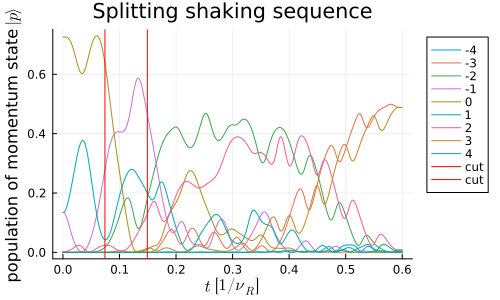

In [292]:
p = Plots.plot(times, pops[:,:]', labels=(-p_max:1:p_max)', legend=:outertopright, size=(500, 300))
Plots.vline!(p, [times[50] + dt/2], color=:red, label="cut")
Plots.vline!(p, [times[100] + dt/2], color=:red, label="cut")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel=L"population of momentum state $|p\rangle$"
)
Plots.title!(p, "Splitting shaking sequence")

In [293]:
system.H_drift_real

9×9 Matrix{Float64}:
 402.124    0.0      0.0     0.0     0.0   0.0       0.0      0.0      0.0
   0.0    226.195    0.0     0.0     0.0   0.0       0.0      0.0      0.0
   0.0      0.0    100.531   0.0     0.0   0.0       0.0      0.0      0.0
   0.0      0.0      0.0    25.1327  0.0   0.0       0.0      0.0      0.0
   0.0      0.0      0.0     0.0     0.0   0.0       0.0      0.0      0.0
   0.0      0.0      0.0     0.0     0.0  25.1327    0.0      0.0      0.0
   0.0      0.0      0.0     0.0     0.0   0.0     100.531    0.0      0.0
   0.0      0.0      0.0     0.0     0.0   0.0       0.0    226.195    0.0
   0.0      0.0      0.0     0.0     0.0   0.0       0.0      0.0    402.124

In [294]:
Z.psi_iso[:,50]

18-element Vector{Float64}:
  0.0006695653362649294
  0.01813116828812884
  0.11116964858439995
  0.3445347281475439
  0.738263394436019
  0.07900599157151939
  0.13989916194382904
  0.007511087485443726
 -0.00010238988876381794
 -0.0006948629511297808
  0.002489006534570441
  0.05970531274448479
  0.38960868941798615
  0.31856631582806905
 -0.19130932603822778
  0.06444570351189406
  0.010701813750041995
  0.0007659212210675008

In [295]:
G * Z.psi_iso[:,50]

MethodError: MethodError: no method matching *(::Vector{Matrix{Float64}}, ::Vector{Float64})

Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:578
  *(!Matched::StridedMatrix{T}, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real}
   @ LinearAlgebra /local/lmseifert/.julia/juliaup/julia-1.9.2+0.x64.linux.gnu/share/julia/stdlib/v1.9/LinearAlgebra/src/matmul.jl:49
  *(::StridedVecOrMat, !Matched::LinearAlgebra.Adjoint{<:Any, <:LinearAlgebra.LQPackedQ})
   @ LinearAlgebra /local/lmseifert/.julia/juliaup/julia-1.9.2+0.x64.linux.gnu/share/julia/stdlib/v1.9/LinearAlgebra/src/lq.jl:269
  ...


In [296]:
Z.psi_iso[:,51]

18-element Vector{Float64}:
  0.0006119020201955618
  0.02073005946275774
  0.12615107164180359
  0.37218140090136265
  0.730808232559246
  0.05662258056629522
  0.14762136256439354
  0.007014962101058694
  0.00010201780264376476
 -0.0010149993836917595
 -0.0023901304556969037
  0.05216709869236957
  0.38509564680731745
  0.30653145896427514
 -0.19672175048342222
  0.04773933817549079
  0.007419527487821181
  0.000577782690601557

In [297]:
norms = [LA.norm(Z.psi_iso[:,t]) for t=1:T]

401-element Vector{Float64}:
 0.9999999999999999
 0.9999999997516216
 1.0000000033126626
 1.0000000303321277
 1.0000001079415435
 1.0000002562236443
 1.0000004792228412
 1.0000007644932443
 1.0000010895376348
 1.0000014309863778
 ⋮
 1.0000000373923965
 1.000000056815679
 1.0000000659143398
 1.0000000692766464
 1.000000070092712
 1.0000000700542657
 1.0000000698269038
 1.0000000695814242
 1.0000000693281945

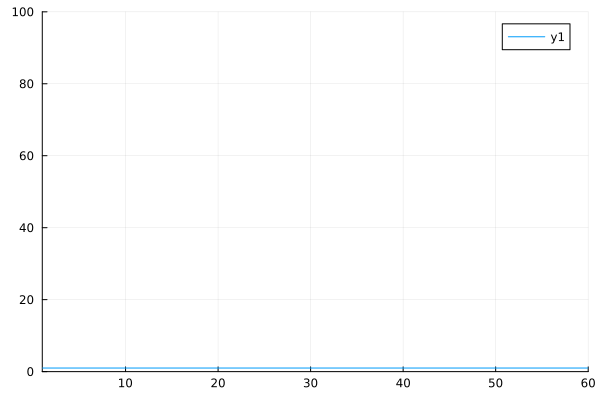

In [298]:
Plots.plot(norms, xlim=(1,60), ylim=(0, 100))

In [300]:
blochs = bloch_states' * psi
bloch_pops = abs2.(blochs)

9×401 Matrix{Float64}:
 1.0          1.0          0.999971     …  2.53489e-8  2.46434e-8  2.30265e-8
 2.13711e-32  7.46387e-28  2.73175e-5      1.97174e-8  1.97287e-8  1.97913e-8
 2.27109e-33  3.02016e-28  9.65585e-8      2.38155e-8  2.58621e-8  3.11644e-8
 1.00616e-34  4.96183e-28  1.4828e-6       2.51634e-8  2.51625e-8  2.49209e-8
 2.59853e-34  2.618e-29    1.24173e-8      5.62695e-7  3.75488e-7  2.85497e-8
 1.07564e-36  1.09865e-27  6.38597e-9   …  0.999999    0.999999    1.0
 2.00235e-36  7.6016e-28   6.65383e-11     4.09327e-9  4.0914e-9   4.08619e-9
 3.29023e-39  1.68406e-28  4.42825e-12     1.02439e-9  1.0481e-9   1.27296e-9
 3.45761e-39  8.04067e-28  1.28274e-13     4.00361e-7  2.50756e-7  5.51642e-9

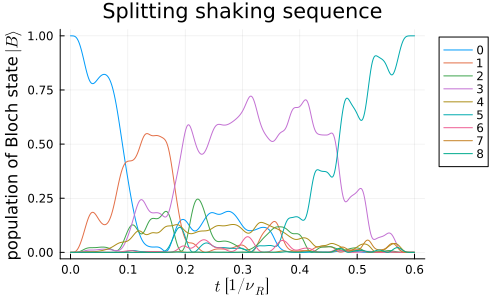

In [301]:
p = Plots.plot(times, bloch_pops[:,:]', labels=(0:dim-1)', legend=:outertopright, size=(500, 300))
# Plots.vline!(p, [times[50] + dt/2], color=:red, label="cut")
# Plots.vline!(p, [times[100] + dt/2], color=:red, label="cut")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel=L"population of Bloch state $|B\rangle$"
)
Plots.title!(p, "Splitting shaking sequence")

In [302]:
x = (;a=10)

(a = 10,)

In [303]:
typeof(x)

NamedTuple{(:a,), Tuple{Int64}}

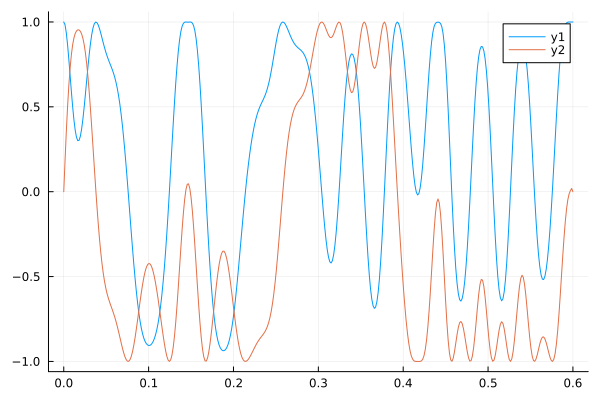

In [304]:
Plots.plot(times, Z.a')

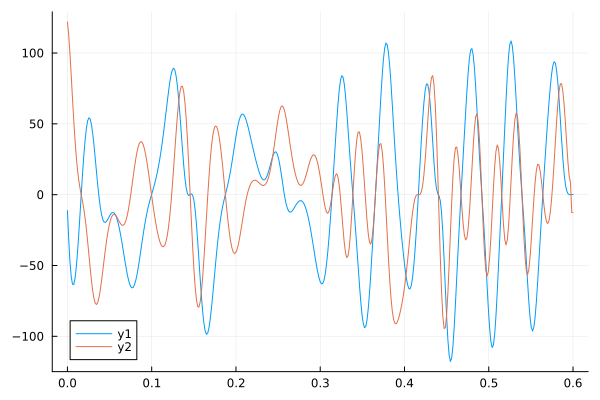

In [305]:
Plots.plot(times, Z.da')

In [306]:
Z.dts

1×401 Matrix{Float64}:
 0.0015  0.0015  0.0015  0.0015  0.0015  …  0.0015  0.0015  0.0015  0.0015

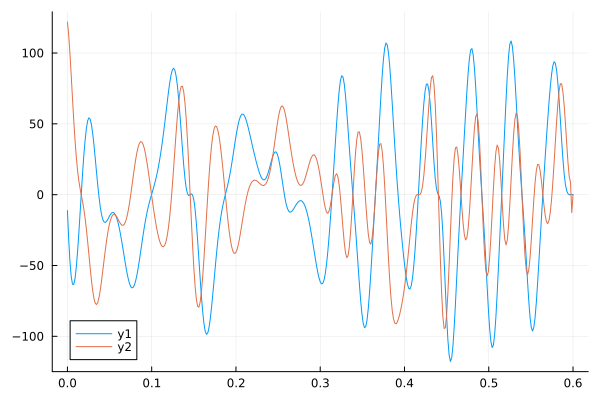

In [307]:
Plots.plot(times, NT.derivative(Z.a, vec(Z.dts))')

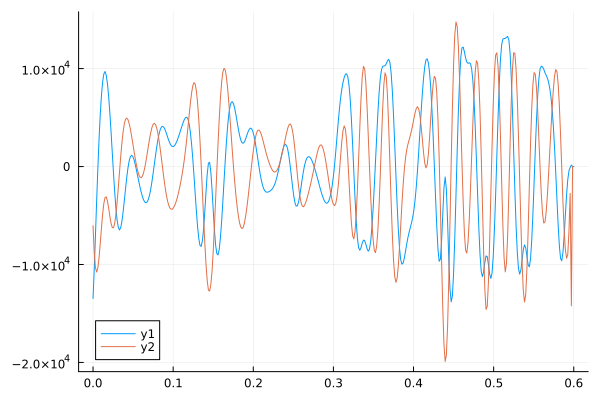

In [308]:
Plots.plot(times, Z.dda')

In [309]:
phi = angle.(Z.a[1,:] + 1im * Z.a[2,:]);

In [310]:
phi_mod_clean(phi)

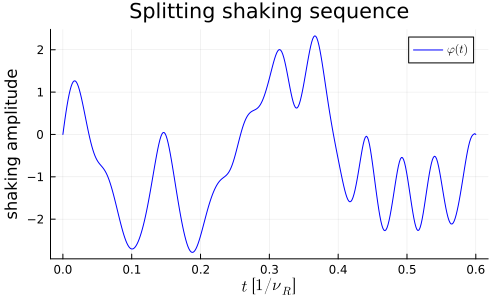

In [311]:
p = Plots.plot(times, phi, linecolor=:blue, label=L"\varphi(t)", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
# Plots.vline!(p, [times[50] + dt/2], color=:red, label="cut")
# Plots.vline!(p, [times[100] + dt/2], color=:red, label="cut")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel="shaking amplitude"
)
Plots.title!(p, "Splitting shaking sequence")

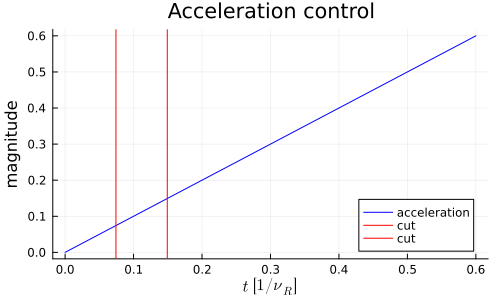

In [313]:
p = Plots.plot(times, Z.acc', linecolor=:blue, label="acceleration", size=(500, 300))
# Plots.plot!(p, times, phase_bound.(times), linecolor=:grey, label="bound")
# Plots.plot!(p, times, -phase_bound.(times), linecolor=:grey, label="bound")
Plots.vline!(p, [times[50] + dt/2], color=:red, label="cut")
Plots.vline!(p, [times[100] + dt/2], color=:red, label="cut")
Plots.xaxis!(p, 
    xlabel=L"$t$ $[1/\nu_R]$"
)
Plots.yaxis!(p, 
    ylabel="magnitude"
)
Plots.title!(p, "Acceleration control")

In [314]:
pops[:,end]

9-element Vector{Float64}:
 0.0039214800967900115
 0.48835749360739306
 0.00771345796804602
 4.635330313429308e-5
 5.070150183715195e-8
 4.544216832507971e-5
 0.007673971781530152
 0.48833131282228937
 0.00391057620738405

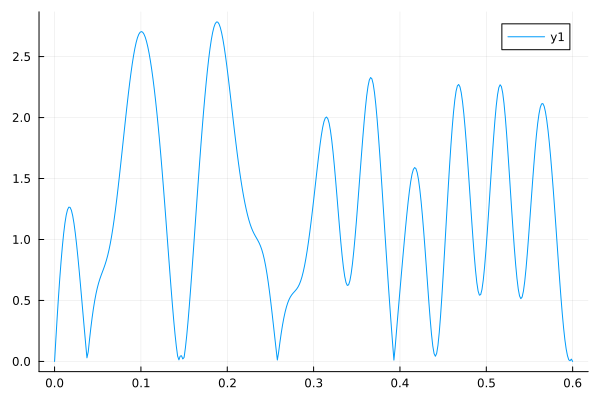

In [315]:
Plots.plot(times, acos.(Z.a[1,:]))

In [317]:
#freqs = collect(12.464:0.001:12.468)
freqs = collect(0.:0.1:25.0)
phi_ft = fourier_time_freq(phi, times, freqs);

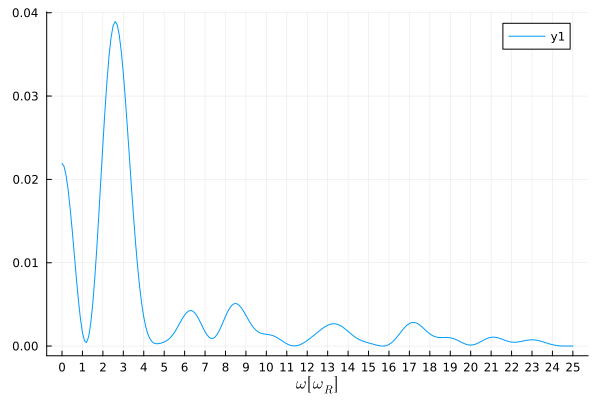

In [318]:
Plots.plot(freqs, abs2.(phi_ft), xticks=(0.0:1.0:maximum(freqs)), xlabel=L"\omega \, [\omega_R]")#, ylims=(0.000895, 0.0009))

In [177]:
Z_guess = Z
Z_save = deepcopy(Z)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([0.00012655239195148894 0.00012652634112418087 … -0.05494332865387438 -0.06060665800454366; 0.003348732119556511 0.003348042546639961 … -0.6975996048515126 -0.6766199657156728; … ; -12063.260059108032 -19709.439845707173 … -0.3014726515807112 0.0; 0.0015 0.0015 … 0.0015 0.0015], [0.00012655239195148894, 0.003348732119556511, 0.05097922316700026, 0.36682320062722157, 0.8518575330001765, 0.36682320062722257, 0.050979223167000404, 0.0033487321195565197, 0.00012655239195148916, -0.0  …  -0.17465935727528792, -0.015628946752469158, 1.0, 0.0, 0.5999999999999969, 67.82324027386062, 292.9686779230019, 0.0, 0.0, 0.0015], 401, :dts, 26, (psi_iso = 18, a = 2, acc = 1, da = 2, dda = 2, dts = 1, states = 24, controls = 2), (dts = ([0.0015], [0.0015]),), (psi_iso = [0.00012655239195148894, 0.003348732119556511, 0.05097922316700026, 0.36682320062722157, 0.8518575330001765, 0.36682320062722257, 0.050979223167000404, 0.0033487321195565197

In [178]:
import JLD2

In [ ]:
JLD2.save("interferometer/split_victor_opt.jld2", Z)